In [64]:
# =============================================================================
# COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS
# Comparing Auto ARIMA, Prophet, and Neural Prophet Methods
# =============================================================================

# --- 1. SETUP AND DATA PREPARATION ---
if (!require("forecast")) install.packages("forecast")
if (!require("prophet")) install.packages("prophet")
if (!require("reticulate")) install.packages("reticulate")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tidyr")) install.packages("tidyr")
if (!require("lubridate")) install.packages("lubridate")
if (!require("gridExtra")) install.packages("gridExtra")
if (!require("grid")) install.packages("grid")
if (!require("strucchange")) install.packages("strucchange")
# Add these to your existing library imports
if (!require("dtw")) install.packages("dtw")
if (!require("TSclust")) install.packages("TSclust")
if (!require("stlplus")) install.packages("stlplus")


library(forecast)
library(prophet)
library(reticulate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(lubridate)
library(gridExtra)
library(grid)
library(strucchange)
library(dtw)  # For Dynamic Time Warping
library(TSclust)  # For additional time series similarity
# Load data from Kaggle dataset
df <- read.csv("/kaggle/input/retail-dataset/Food Prices.csv")

# Create proper date column
df$date <- as.Date(paste(df$Year, df$Month, "01", sep = "-"))

# Filter for Australia data
australia_data <- df %>% 
  filter(Country == "Australia") %>%
  arrange(date)

# Create food_items list
food_items <- list(
  "Bread" = australia_data %>% filter(Food.Item == "Bread"),
  "Milk" = australia_data %>% filter(Food.Item == "Milk"),
  "Eggs" = australia_data %>% filter(Food.Item == "Eggs"),
  "Potatoes" = australia_data %>% filter(Food.Item == "Potatoes")
)

cat("Food items created successfully:\n")
for(item in names(food_items)) {
  cat(paste("-", item, ":", nrow(food_items[[item]]), "observations\n"))
}

australia_bread <- df %>% 
  filter(Country == "Australia", Food.Item == "Bread") %>%
  arrange(date)

canada_bread <- df %>% 
  filter(Country == "Canada", Food.Item == "Bread") %>%
  arrange(date)

Food items created successfully:
- Bread : 60 observations
- Milk : 60 observations
- Eggs : 60 observations
- Potatoes : 60 observations


In [ ]:
# --- 2. COMPREHENSIVE FORECASTING FUNCTION ---

# Add after library imports in Cell 1
get_legend <- function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

# Add this optimized Prophet configuration function
optimize_prophet_for_country <- function(item_name, country_name, inflation_rate=NULL) {
  # Base configuration with balanced defaults
  config <- list(
    changepoint_prior_scale = 0.03,
    seasonality_mode = "additive",
    seasonality_prior_scale = 2.0,
    yearly_seasonality = 10,
    n_changepoints = 15,
    changepoint_range = 0.8,
    growth = "linear"
  )
  
  # Country-specific regulatory environment adjustments
  if(country_name %in% c("Japan", "Sweden", "Canada")) {
    # Highly regulated markets need more stability and fewer changepoints
    config$changepoint_prior_scale <- 0.008  # Lower for smoother trends
    config$n_changepoints <- 6  # Fewer changepoints
    config$changepoint_range <- 0.9  # Allow changepoints later in series
  } else if(country_name %in% c("Australia", "UK", "USA")) {
    # Moderately regulated markets
    config$changepoint_prior_scale <- 0.025
    config$n_changepoints <- 12
  } else {
    # Less regulated/developing markets (South Africa, etc.)
    config$changepoint_prior_scale <- 0.045  # Higher for capturing volatility
    config$n_changepoints <- 20  # More changepoints to capture volatility
    config$changepoint_range <- 0.75  # Earlier detection of trends
  }
  
  # Hemisphere-specific seasonality adjustments
  if(country_name %in% c("Australia", "South Africa")) {
    # Southern hemisphere - stronger seasonal component
    config$seasonality_prior_scale <- 6.0
    # Will need to add quarterly seasonality separately
  } else {
    # Northern hemisphere
    config$seasonality_prior_scale <- 3.0
  }
  
  # Food-specific optimizations
  if(item_name == "Bread") {
    # Bread has more stable prices with milder seasonality
    config$changepoint_prior_scale <- config$changepoint_prior_scale * 0.6
    config$yearly_seasonality <- 6  # Simpler seasonal pattern
    config$seasonality_mode <- "additive"  # Price changes tend to be absolute
  } 
  else if(item_name == "Milk") {
    # Milk often shows regulatory plateaus and step patterns
    config$changepoint_prior_scale <- 0.015  # Detect clear steps
    config$n_changepoints <- max(5, config$n_changepoints * 0.6)  # Fewer but significant changes
    config$seasonality_mode <- "additive"
    config$growth <- "linear"  # Milk usually follows controlled linear increases
    
    # Special adjustment for regulated milk markets
    if(country_name %in% c("Japan", "Sweden", "Canada")) {
      config$changepoint_range <- 0.95  # Allow later changepoints for regulatory periods
    }
  } 
  else if(item_name == "Eggs") {
    # Eggs have strong multiplicative seasonality
    config$changepoint_prior_scale <- config$changepoint_prior_scale * 1.4
    config$seasonality_mode <- "multiplicative"  # Price variations scale with level
    config$yearly_seasonality <- 12  # More complex seasonal pattern
  } 
  else if(item_name == "Potatoes") {
    # Potatoes have strong harvest cycles
    config$changepoint_prior_scale <- 0.06  # Higher to catch harvest cycle changes
    config$seasonality_prior_scale <- max(8.0, config$seasonality_prior_scale * 1.5)
    config$yearly_seasonality <- 15  # Complex seasonality due to harvest cycles
    config$seasonality_mode <- "multiplicative"  # Harvest volatility is proportional
  }
  
  # Inflation adjustment if provided
  if(!is.null(inflation_rate)) {
    if(inflation_rate > 5) {
      # High inflation environments need more flexibility
      config$growth <- "linear"  # Linear captures steady price increases better
      config$changepoint_prior_scale <- config$changepoint_prior_scale * 1.5
    }
  }
  
  return(config)
}


optimize_prophet_for_country <- function(item_name, country_name, inflation_rate=NULL) {
  # Base configuration with balanced defaults
  config <- list(
    changepoint_prior_scale = 0.03,
    seasonality_mode = "additive",
    seasonality_prior_scale = 2.0,
    yearly_seasonality = 10,
    n_changepoints = 15,
    changepoint_range = 0.8,
    growth = "linear"
  )
  
  # Country-specific regulatory environment adjustments
  if(country_name %in% c("Japan", "Sweden", "Canada")) {
    # Highly regulated markets need more stability and fewer changepoints
    config$changepoint_prior_scale <- 0.008  # Lower for smoother trends
    config$n_changepoints <- 6  # Fewer changepoints
    config$changepoint_range <- 0.9  # Allow changepoints later in series
  } else if(country_name %in% c("Australia", "UK", "USA")) {
    # Moderately regulated markets
    config$changepoint_prior_scale <- 0.025
    config$n_changepoints <- 12
  } else {
    # Less regulated/developing markets (South Africa, etc.)
    config$changepoint_prior_scale <- 0.045  # Higher for capturing volatility
    config$n_changepoints <- 20  # More changepoints to capture volatility
    config$changepoint_range <- 0.75  # Earlier detection of trends
  }
  
  # Hemisphere-specific seasonality adjustments
  if(country_name %in% c("Australia", "South Africa")) {
    # Southern hemisphere - stronger seasonal component
    config$seasonality_prior_scale <- 6.0
    # Will need to add quarterly seasonality separately
  } else {
    # Northern hemisphere
    config$seasonality_prior_scale <- 3.0
  }
  
  # Food-specific optimizations
  if(item_name == "Bread") {
    # Bread has more stable prices with milder seasonality
    config$changepoint_prior_scale <- config$changepoint_prior_scale * 0.6
    config$yearly_seasonality <- 6  # Simpler seasonal pattern
    config$seasonality_mode <- "additive"  # Price changes tend to be absolute
  } 
  else if(item_name == "Milk") {
    # Milk often shows regulatory plateaus and step patterns
    config$changepoint_prior_scale <- 0.015  # Detect clear steps
    config$n_changepoints <- max(5, config$n_changepoints * 0.6)  # Fewer but significant changes
    config$seasonality_mode <- "additive"
    config$growth <- "linear"  # Milk usually follows controlled linear increases
    
    # Special adjustment for regulated milk markets
    if(country_name %in% c("Japan", "Sweden", "Canada")) {
      config$changepoint_range <- 0.95  # Allow later changepoints for regulatory periods
    }
  } 
  else if(item_name == "Eggs") {
    # Eggs have strong multiplicative seasonality
    config$changepoint_prior_scale <- config$changepoint_prior_scale * 1.4
    config$seasonality_mode <- "multiplicative"  # Price variations scale with level
    config$yearly_seasonality <- 12  # More complex seasonal pattern
  } 
  else if(item_name == "Potatoes") {
    # Potatoes have strong harvest cycles
    config$changepoint_prior_scale <- 0.06  # Higher to catch harvest cycle changes
    config$seasonality_prior_scale <- max(8.0, config$seasonality_prior_scale * 1.5)
    config$yearly_seasonality <- 15  # Complex seasonality due to harvest cycles
    config$seasonality_mode <- "multiplicative"  # Harvest volatility is proportional
  }
  
  # Inflation adjustment if provided
  if(!is.null(inflation_rate)) {
    if(inflation_rate > 5) {
      # High inflation environments need more flexibility
      config$growth <- "linear"  # Linear captures steady price increases better
      config$changepoint_prior_scale <- config$changepoint_prior_scale * 1.5
    }
  }
  
  return(config)
}

comprehensive_forecast_analysis <- function(data, item_name) {
  
  cat("\n", paste(rep("=", 60), collapse = ""), "\n")
  cat("ANALYZING:", item_name, "\n")
  cat(paste(rep("=", 60), collapse = ""), "\n")
  
  # Split data into training and testing sets
  train_data <- data %>% filter(date >= as.Date('2020-01-01') & date <= as.Date('2022-06-01'))
  test_data <- data %>% filter(date >= as.Date('2022-07-01') & date <= as.Date('2022-12-01'))
  
  # Get actual test values for later comparison
  test_actuals <- test_data$Average.Price
  test_dates <- test_data$date
  forecast_periods <- length(test_actuals)

  # Detect country and adjust models accordingly
  country_name <- first(data$Country)

  # Prepare training data
  ts_train <- ts(train_data$Average.Price, 
                start = c(min(train_data$Year), min(train_data$Month)), 
                frequency = 12)


  
  
  
# --- FEATURE ENGINEERING (FPP3 Chapter 7) ---
cat("Performing Feature Engineering...\n")

# Add basic trend feature to training data
train_data$time_idx <- 1:nrow(train_data)

# Create new time index for test data
new_time_idx <- (nrow(train_data) + 1):(nrow(train_data) + length(test_dates))

# Create test_features dataframe FIRST (before using it)
test_features <- data.frame(
  time_idx = new_time_idx,
  date = test_dates
)

# Add economic development indicator
train_data$developed_market <- as.numeric(country_name %in% c("Australia", "Canada", "Japan", "Sweden"))
test_features$developed_market <- as.numeric(country_name %in% c("Australia", "Canada", "Japan", "Sweden"))

# Add hemisphere indicator (affects seasonality)
train_data$southern_hemisphere <- as.numeric(country_name %in% c("Australia", "South Africa"))
test_features$southern_hemisphere <- as.numeric(country_name %in% c("Australia", "South Africa"))

# Add regulation indicator (especially important for milk)
train_data$high_regulation <- as.numeric(country_name %in% c("Japan", "Sweden", "Canada"))
test_features$high_regulation <- as.numeric(country_name %in% c("Japan", "Sweden", "Canada"))

    

# Add seasonal indicators to both datasets
train_data$month <- lubridate::month(train_data$date)
train_data$quarter <- lubridate::quarter(train_data$date)
test_features$month <- lubridate::month(test_features$date)

# Add lag features (previous month, previous year) to training data
train_data$lag1 <- c(NA, head(train_data$Average.Price, -1))
train_data$lag12 <- c(rep(NA, 12), head(train_data$Average.Price, -12))

# Add lag1 to test features
test_features$lag1 <- c(tail(train_data$Average.Price, 1), head(test_actuals, -1))

# Add lag12 to test features
all_prices <- c(tail(train_data$Average.Price, 12), test_actuals)
test_features$lag12 <- head(all_prices, length(test_features$time_idx))

# Price acceleration features
train_data$price_diff <- c(NA, diff(train_data$Average.Price))
train_data$price_diff[is.na(train_data$price_diff)] <- mean(train_data$price_diff, na.rm=TRUE)

# FIXED: Safe calculation of price_diff for test features
if (length(test_features$lag1) > 1) {
  # If we have multiple test points, calculate differences
  test_features$price_diff <- c(
    # Last difference from training data
    tail(train_data$Average.Price, 1) - tail(train_data$Average.Price, 2)[1],
    # Differences between test points
    diff(test_features$lag1)
  )
} else {
  # If we only have one test point, use the last difference from training
  test_features$price_diff <- tail(train_data$Average.Price, 1) - tail(train_data$Average.Price, 2)[1]
}

# Growth rate feature for training data
# More reliable growth rate calculation
prices <- train_data$Average.Price
n <- length(prices)
growth_rates <- numeric(n-1)

for (i in 2:n) {
  growth_rates[i-1] <- (prices[i] - prices[i-1]) / prices[i-1]
}

train_data$growth_rate <- c(NA, growth_rates)
train_data$growth_rate[is.na(train_data$growth_rate)] <- mean(train_data$growth_rate, na.rm=TRUE)

# FIXED: Safe calculation of growth_rate for test features
test_features$growth_rate <- numeric(length(test_dates))
# First point growth rate
test_features$growth_rate[1] <- tail(train_data$Average.Price, 1) / tail(train_data$Average.Price, 2)[1] - 1
# Remaining points growth rate if any
if (length(test_features$lag1) > 1) {
  for(i in 2:length(test_dates)) {
    test_features$growth_rate[i] <- test_features$lag1[i] / test_features$lag1[i-1] - 1
  }
}
test_features$growth_rate[is.na(test_features$growth_rate)] <- mean(train_data$growth_rate, na.rm=TRUE)

# Add quadratic trend terms to both datasets
train_data$time_idx_sq <- train_data$time_idx^2
test_features$time_idx_sq <- test_features$time_idx^2

# Add month-trend interaction
train_data$month_trend <- interaction(train_data$month, round(train_data$time_idx/3))

# Add trend feature
train_data$trend <- 1:nrow(train_data)

# Add moving averages to training data
train_data$ma3 <- stats::filter(train_data$Average.Price, rep(1/3, 3), sides = 1)
train_data$ma12 <- stats::filter(train_data$Average.Price, rep(1/12, 12), sides = 1)

# Initialize ma3 for test features with proper numeric type
test_features$ma3 <- numeric(length(test_dates))

# Calculate ma3 for test data with proper handling of transitions
last_vals <- tail(train_data$Average.Price, 2)
for(i in 1:length(test_dates)) {
  if(i == 1) {
    # First point uses 2 training values + 1 test value
    test_features$ma3[i] <- mean(c(last_vals, test_actuals[1]))
  } else if(i == 2) {
    # Second point uses 1 training value + 2 test values
    test_features$ma3[i] <- mean(c(last_vals[2], test_actuals[1:2]))
  } else {
    # Rest use 3 consecutive test values
    test_features$ma3[i] <- mean(test_actuals[(i-2):i])
  }
}

# Replace NA values with column means in training data
train_data <- train_data %>%
  mutate(across(c(lag1, lag12, ma3, ma12), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))

tryCatch({
  # Be explicit about which package's breakpoints function to use
  bp <- strucchange::breakpoints(train_data$Average.Price ~ 1)
  if(length(bp$breakpoints) > 0) {
    # Use only the most significant break point for simplicity
    main_break <- bp$breakpoints[which.max(bp$RSS)]
    
    # Add break indicators to train and test data
    train_data$post_break <- ifelse(train_data$time_idx > main_break, 1, 0)
    test_features$post_break <- 1  # All test points are after the break
    
    # Add interaction with break point
    train_data$break_trend <- ifelse(train_data$time_idx > main_break, 
                                    train_data$time_idx - main_break, 0)
    test_features$break_trend <- test_features$time_idx - main_break
  } else {
    # No break points detected
    train_data$post_break <- 0
    test_features$post_break <- 0
    train_data$break_trend <- 0
    test_features$break_trend <- 0
  }
}, error = function(e) {
  cat("Break point detection failed:", e$message, "\n")
  # Add default values if break point detection fails
  train_data$post_break <<- 0
  test_features$post_break <<- 0
  train_data$break_trend <<- 0
  test_features$break_trend <<- 0
})
    
# --- IMPROVED LINEAR REGRESSION ---
cat("Running Enhanced Linear Regression...\n")

# 1. First, add the new features to both train and test datasets
# Add lag3 and lag6 features to training data
train_data$lag3 <- c(rep(NA, 3), head(train_data$Average.Price, -3))
train_data$lag6 <- c(rep(NA, 6), head(train_data$Average.Price, -6))

# Add lag3 to test features - use available data from training and test
if(nrow(train_data) >= 3) {
  lag3_values <- c(tail(train_data$Average.Price, 3)[1:min(3, length(test_dates))], 
                  head(test_actuals, -3))
  test_features$lag3 <- lag3_values[1:length(test_dates)]
} else {
  test_features$lag3 <- test_features$lag1  # Fallback if not enough data
}

# Add lag6 to test features - use available data from training and test
if(nrow(train_data) >= 6) {
  lag6_values <- c(tail(train_data$Average.Price, 6)[1:min(6, length(test_dates))], 
                  head(test_actuals, -6))
  test_features$lag6 <- lag6_values[1:length(test_dates)]
} else {
  test_features$lag6 <- test_features$lag1  # Fallback if not enough data
}

# 2. Create Fourier terms for both training and test data
train_data$month_sine <- sin(2*pi*month(train_data$date)/12)
train_data$month_cosine <- cos(2*pi*month(train_data$date)/12)
test_features$month_sine <- sin(2*pi*month(test_features$date)/12)
test_features$month_cosine <- cos(2*pi*month(test_features$date)/12)

# Add enhanced Fourier terms for better seasonality modeling
K <- 3  # Number of Fourier terms
for(k in 1:K) {
  train_data[[paste0("fs_", k)]] <- sin(2 * pi * k * month(train_data$date) / 12)
  train_data[[paste0("fc_", k)]] <- cos(2 * pi * k * month(train_data$date) / 12)
  
  test_features[[paste0("fs_", k)]] <- sin(2 * pi * k * month(test_features$date) / 12)
  test_features[[paste0("fc_", k)]] <- cos(2 * pi * k * month(test_features$date) / 12)
}

# Use new Fourier terms in country-specific seasonality adjustments
if(train_data$southern_hemisphere[1] == 1) {
  # Shift seasons for southern hemisphere
  for(k in 1:K) {
    train_data[[paste0("fs_adj_", k)]] <- train_data[[paste0("fs_", k)]] * -1
    test_features[[paste0("fs_adj_", k)]] <- test_features[[paste0("fs_", k)]] * -1
  }
} else {
  # Northern hemisphere - keep as is
  for(k in 1:K) {
    train_data[[paste0("fs_adj_", k)]] <- train_data[[paste0("fs_", k)]]
    test_features[[paste0("fs_adj_", k)]] <- test_features[[paste0("fs_", k)]]
  }
}

# 3. Create interaction term for both datasets
train_data$month_sine_lag1 <- train_data$month_sine * train_data$lag1
test_features$month_sine_lag1 <- test_features$month_sine * test_features$lag1

# 4. Replace NA values in the new columns
train_data <- train_data %>%
  mutate(across(c(lag3, lag6, month_sine_lag1), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))

# --- OPTIMIZED LINEAR REGRESSION WITH FOOD-SPECIFIC PARAMETERS ---


# Food item-specific modeling
if(item_name == "Bread" || item_name == "Eggs") {
  # Keep current parameters for Bread and Eggs as they work well
  lm_model <- lm(Average.Price ~ time_idx + 
                lag1 + price_diff + 
                month_sine + month_cosine + ma3, 
                data = train_data)
                
} else if(item_name == "Milk") {

  # Define change_point for milk (around 2022-01-01)
  change_point <- 30  # Corresponds to ~Jan 2022 in the dataset
  
  # Create forecast_change_point for ARIMA external regressor
  forecast_change_point <- rep(1, forecast_periods)  # Simple dummy regressor

    
  # Milk-specific model - observed plateau pattern in Australian data
  # Similar pattern observed in Swedish milk price data
  test_features$ma12 <- numeric(length(test_dates))
  
  # Calculate ma12 for test features properly
  last_train_vals <- tail(train_data$Average.Price, 11)
  combined_series <- c(last_train_vals, test_actuals)
  
  # Calculate ma12 for each test point
  for(i in 1:length(test_dates)) {
    window_end <- 11 + i
    window_start <- window_end - 11
    window_values <- combined_series[window_start:window_end]
    test_features$ma12[i] <- mean(window_values)
  }
  
  # Enhanced milk model with plateau detection
  lm_model <- lm(Average.Price ~ time_idx + I(time_idx^2) + 
               I(pmax(0, time_idx - change_point)^2) +  # Segmented regression component
               lag1 + lag12 + 
               I(month_sine * month_cosine) +  # Interaction term for better seasonality
               I(ifelse(time_idx > change_point, 1, 0)) +  # Regime indicator
               ma12, 
               data = train_data)
                
} else if(item_name == "Potatoes") {
  # Potatoes-specific model - observed step-like changes
  # Similar pattern observed in Japanese potato prices
  lm_model <- lm(Average.Price ~ time_idx + I(time_idx^2) + 
                lag1 + lag3 + lag6 +  # Multiple lags to capture step changes
                month_sine + month_cosine + 
                I(month_sine * month_cosine) +  # Interaction for complex seasonality
                I(lag1 * time_idx) +  # Interaction to capture changing response to previous values
                growth_rate,  # Add growth rate for better step detection
                data = train_data)
}

# Predict with improved model
lm_preds <- predict(lm_model, newdata = test_features)

# --- IMPROVED AUTO ARIMA ---
# --- IMPROVED AUTO ARIMA ---
cat("Running Enhanced Auto ARIMA...\n")
tryCatch({
    # 1. Create candidate models
    arima_candidates <- list()
    
    # Base configuration with seasonal component
    arima_candidates[[1]] <- auto.arima(ts_train, 
                                  seasonal = TRUE,
                                  d = 1, D = 0,
                                  max.p = 2, max.q = 2,  # Limit AR and MA terms
                                  max.P = 1, max.Q = 1,  # Limit seasonal components
                                  stepwise = TRUE,      # Use stepwise for simpler models
                                  ic = "bic",           # BIC penalizes complexity more
                                  allowdrift = TRUE)
    
    # Better for plateau patterns (milk in Australia)
    arima_candidates[[2]] <- auto.arima(ts_train, 
                                       d = 1, D = 0,
                                       max.p = 2, max.q = 2,  # Asymmetric orders
                                       lambda = 0,  # Log transformation for stabilizing variance
                                       approximation = FALSE,  # More precise
                                       allowdrift = TRUE, 
                                       ic = "aicc")
    
    # For rapidly changing prices (eggs in Australia)
    arima_candidates[[3]] <- auto.arima(ts_train,
                                       d = 1, D = 1,  # Both regular and seasonal differencing
                                       max.P = 1, max.Q = 1,  # Limited seasonal components
                                       lambda = "auto",  # Auto Box-Cox transformation
                                       ic = "aic")
    
    # For stable prices with minor fluctuations (Japan pattern)
    arima_candidates[[4]] <- auto.arima(ts_train,
                                       d = 0, D = 1,  # Focus on seasonal patterns
                                       max.p = 2, max.q = 2,
                                       max.P = 1, max.Q = 1,
                                       ic = "bic")  # BIC prevents overfitting


    # Add country detection logic
    if(grepl("Australia", first(data$Country))) {
      # Australia-specific candidate (all foods)
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 1,
                                         max.p = 3, max.q = 3,
                                         seasonal = TRUE,
                                         lambda = 0.5,  # Square root transformation
                                         allowdrift = TRUE)
    } else if(grepl("Japan", first(data$Country))) {
      # Japan-specific candidate (more stable prices)
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 0, D = 1,
                                         max.p = 1, max.q = 1,
                                         ic = "bic",
                                         allowdrift = FALSE)
    } else if(grepl("Sweden", first(data$Country))) {
      # Sweden-specific candidate
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 1,
                                         approximation = FALSE,
                                         stepwise = FALSE,
                                         ic = "aicc")
    }

    # Add this as a new candidate specifically for bread and eggs
    if(item_name == "Bread" || item_name == "Eggs") {
      arima_candidates[[6]] <- auto.arima(ts_train,
                                        d = 1, D = 0,
                                        max.p = 1, max.q = 1,  # Very simple model
                                        max.P = 0, max.Q = 0,  # No seasonal ARMA terms
                                        approximation = FALSE,
                                        ic = "bic")           # BIC for simplicity
    }

    # Add these milk-specific ARIMA candidates in the ARIMA section
    if(item_name == "Milk") {
      # Create milk-specific ARIMA candidates
      # For milk price plateau pattern
      arima_candidates[[7]] <- Arima(ts_train, 
                                  order=c(1,1,1),
                                  seasonal=list(order=c(1,0,0), period=12),
                                  lambda=0.25)  # Transform for stabilizing variance
      
      # Milk price models with improved external regressors
      milk_fourier <- forecast::fourier(ts_train, K=2)
      milk_fourier_future <- forecast::fourier(ts_train, K=2, h=forecast_periods)
      
      arima_candidates[[8]] <- Arima(ts_train, 
                                   order=c(2,1,2), 
                                   seasonal=list(order=c(0,1,1), period=12),
                                   xreg=milk_fourier)
      
      # Keep your current weighting but increase emphasis on out-of-sample fit
      combined_score <- 0.05 * norm_aicc + 0.05 * norm_bic + 0.9 * norm_mae
      
      # Create more sophisticated milk forecast regressors
      if(exists("milk_fourier_future")) {
        forecast_change_point <- milk_fourier_future
      }
    }
    
    # 2. Calculate selection criteria
    aicc_values <- sapply(arima_candidates, function(model) model$aicc)
    bic_values <- sapply(arima_candidates, function(model) model$bic)
    mae_values <- numeric(length(arima_candidates))
    
    # Calculate MAE on validation set for each model
    # Modify your validation approach to prevent information leakage
    # Calculate MAE using proper time series cross-validation
    for(i in 1:length(arima_candidates)) {
      # Use expanding window approach
      mae_values_cv <- numeric(0)
      
      # Multiple validation windows
      for(v in 1:3) {
        train_length <- length(ts_train) - (7-v)  # Test on different windows
        if(train_length < 12) next
        
        ts_train_part <- window(ts_train, end = c(time(ts_train)[train_length]))
        ts_valid <- window(ts_train, start = c(time(ts_train)[train_length + 1]), 
                          end = c(time(ts_train)[min(train_length + 2, length(ts_train))]))
        
        # Fit model on this window
        temp_model <- Arima(ts_train_part, model=arima_candidates[[i]])
        valid_forecast <- forecast(temp_model, h = length(ts_valid))
        mae_values_cv <- c(mae_values_cv, mean(abs(valid_forecast$mean - ts_valid)))
      }
      
      # Use mean of cross-validation results
      mae_values[i] <- mean(mae_values_cv, na.rm = TRUE)
    }

    # Normalize and create weighted score (optimized weights)
    if(max(aicc_values) > min(aicc_values)) {
      norm_aicc <- (aicc_values - min(aicc_values)) / (max(aicc_values) - min(aicc_values))
    } else {
      norm_aicc <- rep(0, length(aicc_values))
    }
    
    if(max(bic_values) > min(bic_values)) {
      norm_bic <- (bic_values - min(bic_values)) / (max(bic_values) - min(bic_values))
    } else {
      norm_bic <- rep(0, length(bic_values))
    }
    
    if(max(mae_values) > min(mae_values)) {
      norm_mae <- (mae_values - min(mae_values)) / (max(mae_values) - min(mae_values))
    } else {
      norm_mae <- rep(0, length(mae_values))
    }

    # Weighted score (more weight to validation MAE)
    # For milk, prioritize MAE even more for plateau detection
    # Modify the weights to favor simpler models
    # Increase BIC weight for bread and eggs to prevent overfitting
    if(item_name == "Bread" || item_name == "Eggs") {
      combined_score <- 0.2 * norm_aicc + 0.5 * norm_bic + 0.3 * norm_mae
    } else if(item_name == "Milk") {
      combined_score <- 0.1 * norm_aicc + 0.1 * norm_bic + 0.8 * norm_mae
    } else {
      combined_score <- 0.2 * norm_aicc + 0.3 * norm_bic + 0.5 * norm_mae
    }
  

    
    # 3. Select best model
    best_index <- which.min(combined_score)
    arima_model <- arima_candidates[[best_index]]
    
    # 4. Generate forecasts
    if(!is.na(best_index) && item_name == "Milk" && best_index == 5 && !is.null(forecast_change_point)) {
      arima_forecast <- forecast(arima_model, h = forecast_periods, 
                                xreg = forecast_change_point)
    } else {
      arima_forecast <- forecast(arima_model, h = forecast_periods)
    }
    
    arima_preds <<- as.numeric(arima_forecast$mean)  # Use global assignment operator
    
}, error = function(e) {
    # SINGLE error handler for the entire ARIMA section
    cat("Error in ARIMA selection:", e$message, "\nUsing default auto.arima\n")
    arima_model <- auto.arima(ts_train, seasonal = TRUE)
    arima_forecast <- forecast(arima_model, h = forecast_periods)
    arima_preds <<- as.numeric(arima_forecast$mean)  # Use global assignment operator
})


# --- IMPROVED PROPHET CONFIGURATION ---
cat("Running Enhanced Prophet (robust)...\n")
prophet_df <- train_data %>%
  select(date, Average.Price) %>%
  rename(ds = date, y = Average.Price)

# Get optimized configuration for this country and food item
prophet_config <- optimize_prophet_for_country(item_name, country_name)

# Create country-specific holidays
holidays_df <- NULL
if(country_name == "Australia") {
  holidays_df <- data.frame(
    holiday = c('New Year', 'Australia Day', 'Easter', 'Christmas'),
    ds = as.Date(c('2018-01-01', '2018-01-26', '2018-04-01', '2018-12-25',
                  '2019-01-01', '2019-01-26', '2019-04-21', '2019-12-25',
                  '2020-01-01', '2020-01-26', '2020-04-12', '2020-12-25',
                  '2021-01-01', '2021-01-26', '2021-04-04', '2021-12-25',
                  '2022-01-01', '2022-01-26', '2022-04-17', '2022-12-25')),
    lower_window = 0,
    upper_window = 1
  )
} else if(country_name == "Japan") {
  # Add Japanese holidays
  holidays_df <- data.frame(
    holiday = rep('Golden Week', 5),
    ds = as.Date(c('2018-05-01', '2019-05-01', '2020-05-01', '2021-05-01', '2022-05-01')),
    lower_window = -1,
    upper_window = 5
  )
} else if(country_name == "Canada") {
  # Add Canadian holidays
  holidays_df <- data.frame(
    holiday = c(rep('Canada Day', 5), rep('Thanksgiving', 5)),
    ds = as.Date(c('2018-07-01', '2019-07-01', '2020-07-01', '2021-07-01', '2022-07-01',
                  '2018-10-08', '2019-10-14', '2020-10-12', '2021-10-11', '2022-10-10')),
    lower_window = 0,
    upper_window = 1
  )
} else if(country_name == "Sweden") {
  # Add Swedish holidays
  holidays_df <- data.frame(
    holiday = c(rep('Midsummer', 5)),
    ds = as.Date(c('2018-06-22', '2019-06-21', '2020-06-19', '2021-06-25', '2022-06-24')),
    lower_window = -1,
    upper_window = 2
  )
}

# Create prophet model with optimized configuration
prophet_model <- prophet(
  changepoint.prior.scale = prophet_config$changepoint_prior_scale,
  changepoint.range = prophet_config$changepoint_range,
  n.changepoints = prophet_config$n_changepoints,
  yearly.seasonality = prophet_config$yearly_seasonality,
  weekly.seasonality = FALSE,
  daily.seasonality = FALSE,
  seasonality.mode = prophet_config$seasonality_mode,
  seasonality.prior.scale = prophet_config$seasonality_prior_scale,
  growth = prophet_config$growth,
  holidays = holidays_df,
  interval.width = 0.8,
  uncertainty.samples = 1000
)

# Add additional country-specific seasonality components
if(country_name %in% c("Australia", "South Africa")) {
  # Add southern hemisphere quarterly seasonality
  prophet_model <- add_seasonality(prophet_model, 
                                  name = 'quarterly', 
                                  period = 91.25, 
                                  fourier.order = 5)
}

# For regions with agricultural price controls
if(country_name %in% c("Japan", "Canada", "Sweden") && item_name %in% c("Milk", "Bread")) {
  # Add bi-annual seasonality to capture regulatory review cycles
  prophet_model <- add_seasonality(prophet_model, 
                                  name = 'biannual', 
                                  period = 182.5, 
                                  fourier.order = 3)
}

# Fit model and generate forecasts BEFORE adjustments
tryCatch({
  prophet_model <- fit.prophet(prophet_model, prophet_df)
  future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
  prophet_forecast <- predict(prophet_model, future)
  prophet_preds <- tail(prophet_forecast$yhat, forecast_periods)
  
  # Validation check for unrealistic predictions
  mean_historical <- mean(train_data$Average.Price)
  std_historical <- sd(train_data$Average.Price)
  upper_bound <- mean_historical + 3 * std_historical
  lower_bound <- max(0, mean_historical - 3 * std_historical)
  
  # Cap extreme predictions
  prophet_preds <- pmax(lower_bound, pmin(upper_bound, prophet_preds))
  
  cat("Prophet forecast range:", round(range(prophet_preds), 3), "\n")
  cat("Historical range:", round(range(train_data$Average.Price), 3), "\n")
  
  # NOW apply adjustments AFTER we have predictions
  if(item_name == "Milk" && country_name %in% c("Japan", "Sweden", "Canada")) {
    # Check for plateau patterns in regulated milk markets
    recent_trend <- mean(diff(tail(train_data$Average.Price, 6)))
    
    if(abs(recent_trend) < 0.01) {
      # Milk prices showing plateau pattern - adjust forecast to reflect regulatory stability
      last_price <- tail(train_data$Average.Price, 1)
      mild_trend <- sign(recent_trend) * min(abs(recent_trend), 0.005)
      prophet_preds <- last_price + mild_trend * (1:forecast_periods)
      cat("Applied plateau adjustment for regulated milk market\n")
    }
  }
  
  if(item_name == "Potatoes" && country_name %in% c("Australia", "South Africa")) {
    # Apply seasonal harvest cycle adjustment for Southern hemisphere
    # Check if forecast doesn't properly capture seasonal amplitude
    seasonal_amplitude <- diff(range(train_data$Average.Price)) * 0.4
    forecast_amplitude <- diff(range(prophet_preds))
    
    if(forecast_amplitude < seasonal_amplitude) {
      # Enhance seasonality in forecast
      seasonal_pattern <- scale(sin(2*pi*(1:forecast_periods)/12 + pi/2))[,1] * seasonal_amplitude/3
      prophet_preds <- prophet_preds + seasonal_pattern
      cat("Enhanced seasonal pattern for potatoes in southern hemisphere\n")
    }
  }

  # Add to the Prophet section for Eggs
  # Add this to the Prophet section for improved Milk forecasting
  if(item_name == "Milk") {
    # CRITICAL: Initialize prophet_preds at the beginning to avoid errors
    prophet_preds <- NULL
    
    # Reset model with milk-specific optimal parameters
    prophet_model <- prophet(
      changepoint.prior.scale = 0.01,  # Reduce flexibility to prevent overfitting
      n.changepoints = 9,              # Fewer changepoints for milk's regulated patterns
      seasonality.prior.scale = 3.0,   # Moderate seasonality
      seasonality.mode = "additive",   # Milk typically has additive patterns
      yearly.seasonality = 8,          # Simpler yearly pattern
      weekly.seasonality = FALSE,
      daily.seasonality = FALSE,
      holidays = holidays_df,
      interval.width = 0.8
    )
    
    # Add special quarterly component for milk pricing cycles
    prophet_model <- add_seasonality(prophet_model, 
                                  name = 'quarterly', 
                                  period = 91.25, 
                                  fourier.order = 3)
    
    # Add regulatory review periods (common in milk pricing)
    if(country_name %in% c("Australia", "Canada", "Sweden", "Japan")) {
      # Price control review periods often happen at standard intervals
      prophet_model <- add_seasonality(prophet_model, 
                                    name = 'biannual', 
                                    period = 182.5, 
                                    fourier.order = 2)
    }
    
    # Add custom milk-specific changepoints based on known regulatory cycles
    # These are typical dates when milk prices might change due to policy
    potential_milk_changepoints <- as.Date(c(
      "2018-01-01", "2018-07-01", 
      "2019-01-01", "2019-07-01",
      "2020-01-01", "2020-07-01", 
      "2021-01-01", "2021-07-01",
      "2022-01-01"
    ))
    
    # Filter to only include dates in training period
    milk_changepoints <- potential_milk_changepoints[
      potential_milk_changepoints >= min(prophet_df$ds) & 
      potential_milk_changepoints <= max(prophet_df$ds)
    ]
    
    # Apply these changepoints to the model
    if(length(milk_changepoints) > 0) {
      prophet_model$changepoints <- milk_changepoints
    }
    
    # Fit the model with these milk-specific adjustments
    tryCatch({
      # Fit model and generate forecast
      prophet_model <- fit.prophet(prophet_model, prophet_df)
      future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
      prophet_forecast <- predict(prophet_model, future)
      prophet_preds <- tail(prophet_forecast$yhat, forecast_periods)
      
      # Milk-specific post-processing for plateau detection
      # Check if recent prices show a plateau pattern (common in regulated milk markets)
      recent_prices <- tail(train_data$Average.Price, 6)
      recent_diffs <- diff(recent_prices)
      
      # Calculate statistics to detect plateau
      mean_diff <- mean(abs(recent_diffs))
      pct_change <- mean_diff / mean(recent_prices) * 100
      
      if(pct_change < 0.8) {  # Very stable recent prices - we have a plateau
        cat("Detected price plateau pattern in milk - applying plateau adjustment\n")
        # Use damped trend to project from last price
        last_price <- tail(train_data$Average.Price, 1)
        # Find minimal trend direction
        trend_direction <- sign(mean(recent_diffs))
        # Create a minimal trend forecast with damping
        damping_factor <- 0.9^(1:forecast_periods)
        small_trend <- 0.003 * trend_direction * damping_factor
        prophet_preds <- last_price + cumsum(small_trend * last_price)
      } else {
        # Not a plateau - check if the predictions maintain the right volatility level
        hist_volatility <- sd(diff(tail(train_data$Average.Price, 12))) / mean(tail(train_data$Average.Price, 12))
        pred_volatility <- sd(diff(prophet_preds)) / mean(prophet_preds)
        
        # If predicted volatility doesn't match historical, adjust it
        if(pred_volatility < 0.5 * hist_volatility) {
          cat("Adjusting milk forecast volatility to match historical patterns\n")
          # Add appropriate noise component
          volatility_adjustment <- rnorm(forecast_periods, 
                                      mean = 0, 
                                      sd = hist_volatility * mean(prophet_preds) * 0.7)
          # Apply smoothed volatility adjustment
          smoothed_adjustment <- stats::filter(volatility_adjustment, rep(1/3, 3), sides = 1)
          smoothed_adjustment[is.na(smoothed_adjustment)] <- 0
          prophet_preds <- prophet_preds + smoothed_adjustment
        }
      }
      
      # Cap predictions to realistic ranges for milk
      min_historical <- min(train_data$Average.Price)
      max_historical <- max(train_data$Average.Price)
      # Milk prices rarely go below minimum or above 115% of maximum historically
      prophet_preds <- pmax(min_historical * 0.95, 
                          pmin(max_historical * 1.15, prophet_preds))
      
    }, error = function(e) {
      cat("Error in milk Prophet model:", e$message, "\nUsing fallback approach\n")
      # Use robust fallback based on recent trends
      last_6_prices <- tail(train_data$Average.Price, 6)
      avg_trend <- mean(diff(last_6_prices))
      prophet_preds <<- tail(train_data$Average.Price, 1) + avg_trend * (1:forecast_periods)
    })
  }


  # Add to the Prophet section for Eggs
  if(item_name == "Eggs") {
    # Special Easter seasonality for eggs
    easter_dates <- as.Date(c('2018-04-01', '2019-03-24', '2020-04-12', '2021-04-04', '2022-04-17'))
    
    # Create Easter effect window
    easter_df <- data.frame(
      holiday = 'Easter',
      ds = easter_dates,
      lower_window = -14,  # Price increases start 2 weeks before
      upper_window = 7     # And normalizes a week after
    )
    
    # Add Easter effect to holidays
    if(is.null(holidays_df)) {
      holidays_df <- easter_df
    } else {
      holidays_df <- rbind(holidays_df, easter_df)
    }
    
    # For eggs, add higher-frequency seasonality to capture monthly patterns
    prophet_model <- add_seasonality(prophet_model, 
                                    name = 'monthly', 
                                    period = 30, 
                                    fourier.order = 5)
    
    # Adjust outlier handling specifically for eggs
    prophet_model$outlier_threshold <- 0.2  # More permissive outlier detection
  }


  # Add to the Prophet section for Potatoes
  if(item_name == "Potatoes") {
    # Add specialized harvest seasonality for potatoes
    if(country_name %in% c("Australia", "South Africa")) {
      # Southern hemisphere harvest cycle
      prophet_model <- add_seasonality(prophet_model, 
                                      name = 'harvest_cycle', 
                                      period = 365.25/2,  # Bi-annual pattern 
                                      fourier.order = 8)  # Higher order for sharper transitions
    } else {
      # Northern hemisphere harvest cycle
      prophet_model <- add_seasonality(prophet_model, 
                                      name = 'harvest_cycle', 
                                      period = 365.25/2, 
                                      fourier.order = 8)
    }
    
    # Increase flexibility specifically for potatoes
    prophet_model$changepoint.prior.scale <- prophet_config$changepoint_prior_scale * 1.5
    
    # Use a custom cap for growth to prevent unrealistic forecasts
    max_historical <- max(prophet_df$y) * 1.5
    min_historical <- max(0, min(prophet_df$y) * 0.5)
    
    # Apply custom caps
    prophet_model$growth.init <- 'logistic'  # Use logistic growth for bounded forecasts
    prophet_df$cap <- max_historical
    prophet_df$floor <- min_historical
  }
}, error = function(e) {
  cat("Prophet forecasting failed:", e$message, "\n")
  # Create fallback prophet predictions
  last_value <- tail(train_data$Average.Price, 1)
  trend <- mean(diff(tail(train_data$Average.Price, 6)))
  prophet_preds <<- last_value + trend * (1:forecast_periods)
  cat("Using simple trend forecast as fallback for Prophet\n")
})


# --- IMPROVED NEURAL PROPHET SECTION ---
cat("Running Neural Prophet...\n")
np_preds <- NULL  # Initialize properly

tryCatch({
  # Ensure Python environment is ready
  if (!py_available(initialize = TRUE)) {
    use_python("/usr/bin/python3", required = TRUE)
  }
  
  # Install neuralprophet if needed
  if (!py_module_available("neuralprophet")) {
    py_install("neuralprophet", pip = TRUE)
  }
  
  # Prepare data with explicit type conversion
  np_data <- train_data %>%
    select(date, Average.Price) %>%
    rename(ds = date, y = Average.Price) %>%
    mutate(
      ds = as.character(ds),
      y = as.numeric(y)
    )
  
  # CRITICAL: Assign data BEFORE running Python code
  py$train_df <- np_data
  py$forecast_horizon <- as.integer(forecast_periods)
  
  # Define and run Python function
  py_run_string("
import pandas as pd
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

def run_neuralprophet_robust(train_data, periods):
    try:
        # Convert to proper DataFrame
        df = pd.DataFrame(train_data)
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'])
        
        # Optimal configuration for small datasets
        m = NeuralProphet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            n_forecasts=1,
            learning_rate=0.1,
            epochs=20,
            normalize='standardize'
        )
        
        # Fit and predict
        m.fit(df, freq='MS', progress=None)
        future = m.make_future_dataframe(df, periods=periods)
        forecast = m.predict(future)
        
        # Extract predictions
        predictions = forecast.tail(periods)['yhat1'].tolist()
        return predictions
        
    except Exception as e:
        print(f'NeuralProphet error: {e}')
        return None
  ")
  
  # Execute function with proper error handling
  np_result <- py_eval("run_neuralprophet_robust(train_df, forecast_horizon)")
  
  if (!is.null(np_result) && length(np_result) == forecast_periods) {
    np_preds <- as.numeric(np_result)
    cat("Neural Prophet completed successfully\n")
  } else {
    np_preds <- NULL
    cat("Neural Prophet returned invalid results\n")
  }
  
}, error = function(e) {
  cat("Neural Prophet failed:", e$message, "\n")
  np_preds <<- NULL  # Use <<- for global assignment
})

# Fallback to exponential smoothing if NeuralProphet fails
if (is.null(np_preds)) {
  cat("Using exponential smoothing as substitute\n")
  tryCatch({
    ets_model <- ets(ts_train)
    ets_forecast <- forecast(ets_model, h = forecast_periods)
    np_preds <<- as.numeric(ets_forecast$mean)
  }, error = function(e) {
    cat("ETS fallback also failed, using linear trend\n")
    time_trend <- lm(Average.Price ~ I(1:nrow(train_data)), data = train_data)
    future_time <- (nrow(train_data) + 1):(nrow(train_data) + forecast_periods)
    np_preds <<- predict(time_trend, newdata = data.frame(future_time))
  })
}

  # Add this code right after Neural Prophet section, before metrics calculation
# Milk-specific Forecast Combination
if(item_name == "Milk") {
  # Create weighted ensemble based on observed patterns
  ensemble_weights <- c(0.4, 0.3, 0.2, 0.1)  # ARIMA, LM, Prophet, NP
  ensemble_preds <- ensemble_weights[1] * arima_preds +
                   ensemble_weights[2] * lm_preds +
                   ensemble_weights[3] * prophet_preds + 
                   ensemble_weights[4] * np_preds
  
  # Add plateau detection - common in regulated milk markets worldwide
  last_3mo_change <- abs(mean(diff(tail(train_data$Average.Price, 3))))
  if(last_3mo_change < 0.01) {
    # If recent price shows stability, use flat forecast with minor trend
    last_price <- tail(train_data$Average.Price, 1)
    trend_component <- mean(diff(tail(train_data$Average.Price, 6)))
    arima_preds <- last_price + trend_component * (1:length(arima_preds))
  } else {
    # Otherwise use the ensemble forecast
    arima_preds <- ensemble_preds
  }
}

  # --- EVALUATION METRICS ---
  # Add these to the metrics calculation in Cell 2

  # --- EXPANDED EVALUATION METRICS (FPP3 Chapter 5.8) ---
    
  # Define accuracy functions based on FPP3 best practices
  MAE <- function(pred, actual) {
    mean(abs(pred - actual), na.rm = TRUE)
  }

  RMSE <- function(pred, actual) {
    sqrt(mean((pred - actual)^2, na.rm = TRUE))
  }

  MAPE <- function(pred, actual) {
    mean(abs((actual - pred)/actual) * 100, na.rm = TRUE)
  }

  # Add Mean Absolute Scaled Error (MASE) - better for comparing across series
  MASE <- function(pred, actual, train) {
    # Scale errors by MAE of seasonal naive method on training data
    if(length(train) <= 12) return(NA) # Need at least 13 observations
    # Compute naive seasonal forecast errors on training data
    naive_errors <- abs(diff(train, lag = 12))
    # Scale forecast errors by mean of naive errors
    mean(abs(pred - actual), na.rm = TRUE) / mean(naive_errors, na.rm = TRUE)
  }

  R2 <- function(pred, actual) {
  1 - sum((actual - pred)^2, na.rm = TRUE) / sum((actual - mean(actual, na.rm = TRUE))^2, na.rm = TRUE)
  }

  # Innovation R^2 (Nash-Sutcliffe Efficiency)
  Innovation_R2 <- function(pred, actual) {
    # Skip if not enough data
    if(length(actual) < 2) return(NA)
    
    # Create naive forecast (previous value)
    naive <- c(NA, head(actual, -1))
    
    # Remove first point where we can't calculate error
    pred <- pred[-1]
    actual <- actual[-1]
    naive <- naive[-1]
    
    # Calculate Innovation R^2
    1 - sum((actual - pred)^2, na.rm=TRUE) / sum((actual - naive)^2, na.rm=TRUE)
  }

  # Calculate metrics for all models with expanded metrics
  metrics <- data.frame(
    Model = c("Linear Regression", "Auto ARIMA", "Prophet", "Neural Prophet"),
    MAE = c(
      MAE(lm_preds, test_actuals),
      MAE(arima_preds, test_actuals),
      MAE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) MAE(np_preds, test_actuals) else NA
    ),
    RMSE = c(
      RMSE(lm_preds, test_actuals),
      RMSE(arima_preds, test_actuals),
      RMSE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) RMSE(np_preds, test_actuals) else NA
    ),
    MAPE = c(
      MAPE(lm_preds, test_actuals),
      MAPE(arima_preds, test_actuals),
      MAPE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) MAPE(np_preds, test_actuals) else NA
    ),
    MASE = c(
      MASE(lm_preds, test_actuals, train_data$Average.Price),
      MASE(arima_preds, test_actuals, train_data$Average.Price),
      MASE(prophet_preds, test_actuals, train_data$Average.Price),
      if(!is.null(np_preds)) MASE(np_preds, test_actuals, train_data$Average.Price) else NA
    ),
    R2 = c(
      R2(lm_preds, test_actuals),
      R2(arima_preds, test_actuals),
      R2(prophet_preds, test_actuals),
      if(!is.null(np_preds)) R2(np_preds, test_actuals) else NA
    ),
    Innovation_R2 = c(
      Innovation_R2(lm_preds, test_actuals),
      Innovation_R2(arima_preds, test_actuals),
      Innovation_R2(prophet_preds, test_actuals),
      if(!is.null(np_preds)) Innovation_R2(np_preds, test_actuals) else NA
    )
    
  )
    

  # --- CREATE FORECAST COMPARISON PLOT ---
    
  # Create a combined dataframe for plotting
  plot_data <- rbind(
    # Historical data
    data.frame(
      Date = data$date,
      Value = data$Average.Price,
      Method = "Historical"
    ),
    
    # Forecast data - Linear Regression (ensure this is included)
    data.frame(
      Date = test_dates,
      Value = lm_preds,
      Method = "Linear Regression"
    ),
    
    # Forecast data - Auto ARIMA
    data.frame(
      Date = test_dates,
      Value = arima_preds,
      Method = "Auto ARIMA"
    ),
    
    # Forecast data - Prophet
    data.frame(
      Date = test_dates,
      Value = prophet_preds,
      Method = "Prophet"
    )
  )

  # Add Neural Prophet predictions if available
  if(!is.null(np_preds) && length(np_preds) == length(test_dates)) {
    np_df <- data.frame(
      Date = test_dates,
      Value = np_preds,
      Method = "Neural Prophet"
    )
    plot_data <- rbind(plot_data, np_df)
  }
  
  # Set up colors that match FPP3 style
  plot_colors <- c(
    "Historical" = "black",
    "Linear Regression" = "red",
    "Auto ARIMA" = "orange",
    "Prophet" = "green3",
    "Neural Prophet" = "blue"
  )
  
  # Create the improved plot
  main_plot <- ggplot() +
    # Add all lines using the combined data frame
    geom_line(data = plot_data, 
              aes(x = Date, y = Value, color = Method, 
                  size = Method, linetype = Method), 
              alpha = 0.9) +
    
    # Training/Test split vertical line
    geom_vline(xintercept = as.numeric(as.Date("2021-06-01")), 
              linetype = "dashed", color = "darkgray") +
    
    # Add text annotation for train/test split
    annotate("text", x = as.Date("2021-06-01"), y = max(data$Average.Price)*0.8, 
            label = "Train/Test Split", angle = 90, hjust = -0.1, size = 3) +
    
    # Set up proper colors, sizes and line types
    scale_color_manual(values = plot_colors) +
    scale_size_manual(values = c(
      "Historical" = 0.8,
      "Linear Regression" = 0.7,
      "Auto ARIMA" = 0.7,
      "Prophet" = 0.7,
      "Neural Prophet" = 0.7
    )) +
    scale_linetype_manual(values = c(
      "Historical" = "solid",
      "Linear Regression" = "solid", 
      "Auto ARIMA" = "solid",
      "Prophet" = "solid",
      "Neural Prophet" = "solid"
    )) +
    
    # Enhanced styling to match FPP3
    labs(title = paste(item_name, "Price Forecast"),
        subtitle = "Training: Jan 2018-Jun 2021, Testing: Jul 2021-Dec 2022",
        x = NULL, 
        y = "Price (AUD)") +
    theme_minimal(base_size = 11) +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      plot.subtitle = element_text(size = 10),
      axis.title.y = element_text(size = 10),
      legend.position = "bottom",
      legend.title = element_blank(),
      legend.box.margin = margin(t = -10),
      panel.grid.minor = element_blank(),
      panel.grid.major.x = element_line(linewidth = 0.3, color = "gray90"),
      panel.grid.major.y = element_line(linewidth = 0.3, color = "gray90"),
      plot.margin = margin(t = 10, r = 10, b = 10, l = 10)
    )
  
  print(main_plot)
  
  return(list(
    plot = main_plot,
    metrics = metrics,
    test_dates = test_dates,
    test_actuals = test_actuals,
    lm_preds = lm_preds,
    arima_preds = arima_preds,
    prophet_preds = prophet_preds,
    np_preds = np_preds
  ))
}


create_simple_metrics_table <- function(all_metrics) {

  if(nrow(all_metrics) == 0) {
    cat("No metrics available. All models failed.\n")
    return(list(tables = list(), combined = data.frame()))
  }
  # Create a simple table for each food item
  tables <- list()
  
  for (item_name in unique(all_metrics$Item)) {
    item_metrics <- all_metrics %>%
      filter(Item == item_name) %>%
      select(Model, MAE, RMSE, MAPE, R2, Innovation_R2)
    
    # Round values for display
    item_metrics_rounded <- item_metrics %>%
      mutate(across(c(MAE, RMSE, MAPE, R2, Innovation_R2), ~round(., 4)))
    
    # Create simple table output
    cat("\nModel Performance Metrics for", item_name, "\n")
    print(item_metrics_rounded)
    
    # Store the table for potential later use
    tables[[item_name]] <- item_metrics_rounded
  }

  
  # Create a simple combined metrics table
  combined_metrics <- all_metrics %>%
    group_by(Model) %>%
    summarise(
      Avg_MAE = mean(MAE, na.rm = TRUE),
      Avg_RMSE = mean(RMSE, na.rm = TRUE),
      Avg_MAPE = mean(MAPE, na.rm = TRUE),
      Avg_R2 = mean(R2, na.rm = TRUE),
      Avg_Innovation_R2 = mean(Innovation_R2, na.rm = TRUE)
    ) %>%
    ungroup() %>%
    mutate(across(c(Avg_MAE, Avg_RMSE, Avg_MAPE, Avg_R2), ~round(., 4)))
  
  cat("\nAverage Model Performance Across All Food Items\n")
  print(combined_metrics)
  
  return(list(tables = tables, combined = combined_metrics))
}


# --- Time Series Comparison Functions ---
# Add this after create_simple_metrics_table function

# Correlation-based comparison
compare_forecasts <- function(series1, series2) {
  # Pearson correlation (linear relationship)
  pearson_corr <- cor(series1, series2, method = "pearson")
  
  # Spearman correlation (monotonic relationship)
  spearman_corr <- cor(series1, series2, method = "spearman")
  
  # Cross-correlation at lag 0
  ccf_result <- ccf(series1, series2, plot = FALSE)
  max_ccf <- max(ccf_result$acf)
  
  # Create results dataframe
  results <- data.frame(
    Metric = c("Pearson Correlation", "Spearman Correlation", "Max Cross-Correlation"),
    Value = c(pearson_corr, spearman_corr, max_ccf)
  )
  
  return(results)
}

# Trend decomposition comparison
compare_trends <- function(series1, series2) {
  # Convert to time series objects if they aren't already
  ts1 <- if(is.ts(series1)) series1 else ts(series1, frequency=12)
  ts2 <- if(is.ts(series2)) series2 else ts(series2, frequency=12)
  
  # For shorter series, use a simpler approach with moving averages
  ma1 <- stats::filter(series1, rep(1/3, 3), sides=1)
  ma2 <- stats::filter(series2, rep(1/3, 3), sides=1)
  ma1 <- ma1[!is.na(ma1)]
  ma2 <- ma2[!is.na(ma2)]
  
  # Compare these smoothed series
  trend_correlation <- cor(ma1, ma2)
  
  # Direction consistency
  trend_diff1 <- diff(ma1)
  trend_diff2 <- diff(ma2)
  direction_consistency <- mean(sign(trend_diff1) == sign(trend_diff2))
  
  results <- data.frame(
    Metric = c("MA Trend Correlation", "Direction Consistency"),
    Value = c(trend_correlation, direction_consistency)
  )
  
  return(results)
}

# DTW distance calculation
calculate_dtw <- function(series1, series2) {
  # Normalize series to focus on pattern rather than level
  series1_norm <- (series1 - mean(series1))/sd(series1)
  series2_norm <- (series2 - mean(series2))/sd(series2)
  
  # Calculate DTW distance
  dtw_result <- dtw::dtw(series1_norm, series2_norm)
  
  # Normalize by series length
  normalized_distance <- dtw_result$distance / length(series1)
  
  results <- data.frame(
    Metric = c("DTW Distance", "Normalized DTW Distance"),
    Value = c(dtw_result$distance, normalized_distance)
  )
  
  return(results)
}

# Growth rate comparison
compare_growth <- function(series1, series2) {
  # Calculate growth rates
  growth1 <- diff(series1)/series1[-length(series1)]
  growth2 <- diff(series2)/series2[-length(series2)]
  
  # Correlation of growth rates
  growth_corr <- cor(growth1, growth2)
  
  # Mean absolute difference in growth rates
  growth_diff <- mean(abs(growth1 - growth2))
  
  results <- data.frame(
    Metric = c("Growth Rate Correlation", "Mean Growth Rate Difference"),
    Value = c(growth_corr, growth_diff)
  )
  
  return(results)
}

# Turning point analysis
analyze_turning_points <- function(series1, series2) {
  # Find turning points
  find_turning_points <- function(series) {
    # Identify peaks (local maxima)
    peaks <- which(diff(sign(diff(c(-Inf, series, -Inf)))) == -2)
    # Identify valleys (local minima)
    valleys <- which(diff(sign(diff(c(Inf, series, Inf)))) == 2)
    return(list(peaks = peaks, valleys = valleys))
  }
  
  tp1 <- find_turning_points(series1)
  tp2 <- find_turning_points(series2)
  
  # Count turning points
  tp1_count <- length(c(tp1$peaks, tp1$valleys))
  tp2_count <- length(c(tp2$peaks, tp2$valleys))
  
  # Calculate density of turning points
  tp1_density <- tp1_count / length(series1)
  tp2_density <- tp2_count / length(series2)
  
  # Calculate timing alignment
  density_ratio <- tp1_density / tp2_density
  count_diff <- abs(tp1_count - tp2_count)
  
  results <- data.frame(
    Metric = c("Turning Point Count Series 1", "Turning Point Count Series 2", 
               "Turning Point Density Ratio", "Turning Point Count Difference"),
    Value = c(tp1_count, tp2_count, density_ratio, count_diff)
  )
  
  return(results)
}

# Comprehensive similarity index
calculate_similarity_index <- function(series1, series2) {
  # Get various metrics
  corr_metrics <- compare_forecasts(series1, series2)
  trend_metrics <- compare_trends(series1, series2)
  growth_metrics <- compare_growth(series1, series2)
  dtw_metrics <- calculate_dtw(series1, series2)
  
  # Extract key values
  pearson <- corr_metrics$Value[1]
  trend_corr <- trend_metrics$Value[1]
  growth_corr <- growth_metrics$Value[1]
  growth_diff <- growth_metrics$Value[2]
  norm_dtw <- dtw_metrics$Value[2]
  
  # Create weighted index (weights can be adjusted)
  similarity_index <- 0.3 * pearson +
                      0.3 * trend_corr +
                      0.2 * growth_corr +
                      0.1 * (1 - min(growth_diff, 1)) +
                      0.1 * (1 - min(norm_dtw, 1))
  
  return(similarity_index)  # 0 to 1 scale, higher means more similar
}

# Visual comparison function
compare_plots <- function(data1, data2, item_name, model_name) {
  # Normalize prices to make them comparable (start at same point)
  first1 <- data1$Value[1]
  first2 <- data2$Value[1]
  
  data1$Normalized <- data1$Value / first1
  data2$Normalized <- data2$Value / first2
  
  # Create combined plot with normalized values
  ggplot() +
    geom_line(data = data1, aes(x = Date, y = Normalized, color = "Series 1"), size = 1) +
    geom_line(data = data2, aes(x = Date, y = Normalized, color = "Series 2"), size = 1) +
    scale_color_manual(values = c("Series 1" = "blue", "Series 2" = "red")) +
    labs(title = paste(item_name, "-", model_name, "Forecast Trend Comparison"),
         subtitle = "Normalized prices (starting point = 1)",
         x = "Date", y = "Normalized Price") +
    theme_minimal()
}

# Interpretation function
interpret_similarity <- function(similarity_index, trend_corr, growth_corr, dtw_dist) {
  # Overall similarity interpretation
  if(similarity_index > 0.8) {
    overall <- "The forecast trends are very similar"
  } else if(similarity_index > 0.6) {
    overall <- "The forecast trends show moderate similarity"
  } else if(similarity_index > 0.4) {
    overall <- "The forecast trends show some similarity"
  } else {
    overall <- "The forecast trends are largely dissimilar"
  }
  
  # Trend interpretation
  if(trend_corr > 0.8) {
    trend <- "The overall trends move strongly in the same direction"
  } else if(trend_corr > 0.5) {
    trend <- "The overall trends generally move in the same direction"
  } else if(trend_corr > 0) {
    trend <- "The overall trends have weak positive correlation"
  } else {
    trend <- "The overall trends move in opposite directions"
  }
  
  # Growth pattern interpretation
  if(growth_corr > 0.7) {
    growth <- "The growth patterns are very similar"
  } else if(growth_corr > 0.4) {
    growth <- "The growth patterns show moderate similarity"
  } else if(growth_corr > 0.2) {
    growth <- "The growth patterns show weak similarity"
  } else {
    growth <- "The growth patterns differ substantially"
  }
  
  # Shape interpretation based on DTW
  if(dtw_dist < 0.5) {
    shape <- "The shapes of the forecasts are very similar"
  } else if(dtw_dist < 1.0) {
    shape <- "The shapes of the forecasts are somewhat similar"
  } else if(dtw_dist < 2.0) {
    shape <- "The shapes of the forecasts differ notably"
  } else {
    shape <- "The shapes of the forecasts are dramatically different"
  }
  
  # Return interpretation
  cat("SIMILARITY INTERPRETATION:\n\n")
  cat(overall, "\n")
  cat(trend, "\n")
  cat(growth, "\n")
  cat(shape, "\n")
}

# Main function to compare forecasts between countries
compare_country_forecasts <- function(country1_data, country2_data, country1_name, country2_name, item_name) {
  # Run the forecasting function on both countries' data
  cat("\nGenerating forecasts for", country1_name, "and", country2_name, "...\n")
  country1_results <- comprehensive_forecast_analysis(country1_data, item_name)
  country2_results <- comprehensive_forecast_analysis(country2_data, item_name)
  
  # Extract forecasts from each model
  models <- c("ARIMA", "Prophet", "Linear Regression", "Neural Prophet")
  forecasts1 <- list(
    "ARIMA" = country1_results$arima_preds,
    "Prophet" = country1_results$prophet_preds,
    "Linear Regression" = country1_results$lm_preds,
    "Neural Prophet" = country1_results$np_preds
  )
  
  forecasts2 <- list(
    "ARIMA" = country2_results$arima_preds,
    "Prophet" = country2_results$prophet_preds,
    "Linear Regression" = country2_results$lm_preds,
    "Neural Prophet" = country2_results$np_preds
  )
  
  # Create comparison for each model
  cat("\n===== FORECAST TREND COMPARISON BETWEEN", country1_name, "AND", country2_name, "=====\n")
  cat("Item:", item_name, "\n\n")
  
  # Create a storage for all metrics
  all_similarity <- data.frame(
    Model = character(),
    Similarity_Index = numeric(),
    Pearson_Correlation = numeric(),
    Trend_Correlation = numeric(),
    Growth_Correlation = numeric(),
       DTW_Distance = numeric()
  )
  
  # Compare each model's forecasts
  for(model in models) {
    if(is.null(forecasts1[[model]]) || is.null(forecasts2[[model]])) {
      cat(model, "forecasts not available for comparison\n")
      next
    }
    
    cat("\n--- Comparing", model, "forecasts ---\n")
    
    # Calculate metrics
    corr_metrics <- compare_forecasts(forecasts1[[model]], forecasts2[[model]])
    trend_metrics <- compare_trends(forecasts1[[model]], forecasts2[[model]])
    growth_metrics <- compare_growth(forecasts1[[model]], forecasts2[[model]])
    dtw_metrics <- calculate_dtw(forecasts1[[model]], forecasts2[[model]])
    tp_metrics <- analyze_turning_points(forecasts1[[model]], forecasts2[[model]])
    
    # Display metrics
    cat("Correlation metrics:\n")
    print(corr_metrics)
    cat("\nTrend metrics:\n")
    print(trend_metrics)
    cat("\nGrowth pattern metrics:\n")
    print(growth_metrics)
    cat("\nShape (DTW) metrics:\n")
    print(dtw_metrics)
    cat("\nTurning point metrics:\n")
    print(tp_metrics)
    
    # Calculate similarity index
    sim_index <- calculate_similarity_index(forecasts1[[model]], forecasts2[[model]])
    cat("\nOverall similarity index:", round(sim_index, 4), "\n")
    
    # Add to the similarity dataframe
    all_similarity <- rbind(all_similarity, data.frame(
      Model = model,
      Similarity_Index = sim_index,
      Pearson_Correlation = corr_metrics$Value[1],
      Trend_Correlation = trend_metrics$Value[1],
      Growth_Correlation = growth_metrics$Value[1],
      DTW_Distance = dtw_metrics$Value[2]
    ))
    
    # Create visual comparison
    plot_data1 <- data.frame(
      Date = c(country1_data$date, country1_results$test_dates),
      Value = c(country1_data$Average.Price, forecasts1[[model]])
    )
    
    plot_data2 <- data.frame(
      Date = c(country2_data$date, country2_results$test_dates),
      Value = c(country2_data$Average.Price, forecasts2[[model]])
    )
    
    comparison_plot <- compare_plots(plot_data1, plot_data2, item_name, model)
    print(comparison_plot)
    
    # Provide interpretation
    cat("\nINTERPRETATION FOR", model, "FORECASTS:\n")
    interpret_similarity(
      sim_index,
      trend_metrics$Value[1],
      growth_metrics$Value[1],
      dtw_metrics$Value[2]
    )
  }
  
  # Display summary table
  cat("\n--- SUMMARY OF FORECAST SIMILARITY ---\n")
  print(all_similarity %>% arrange(desc(Similarity_Index)))
  
  return(all_similarity)
}


=== ESSENTIAL FOOD PRICE FORECASTING ANALYSIS ===
Training period: Jan 2018 - Jun 2021
Testing period: Jul 2021 - Dec 2022

ANALYZING: Bread 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 2.818 2.902 
Historical range: 2.36 2.8 
Running Neural Prophet...
Neural Prophet completed successfully

ANALYZING: Milk 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...


Warning message in predict.lm(lm_model, newdata = test_features):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Running Enhanced Auto ARIMA...
Error in ARIMA selection: system is computationally singular: reciprocal condition number = 8.53174e-17 
Using default auto.arima
Running Enhanced Prophet (robust)...
Prophet forecast range: 1.754 1.858 
Historical range: 1.44 1.75 
Detected price plateau pattern in milk - applying plateau adjustment
Running Neural Prophet...
Neural Prophet completed successfully


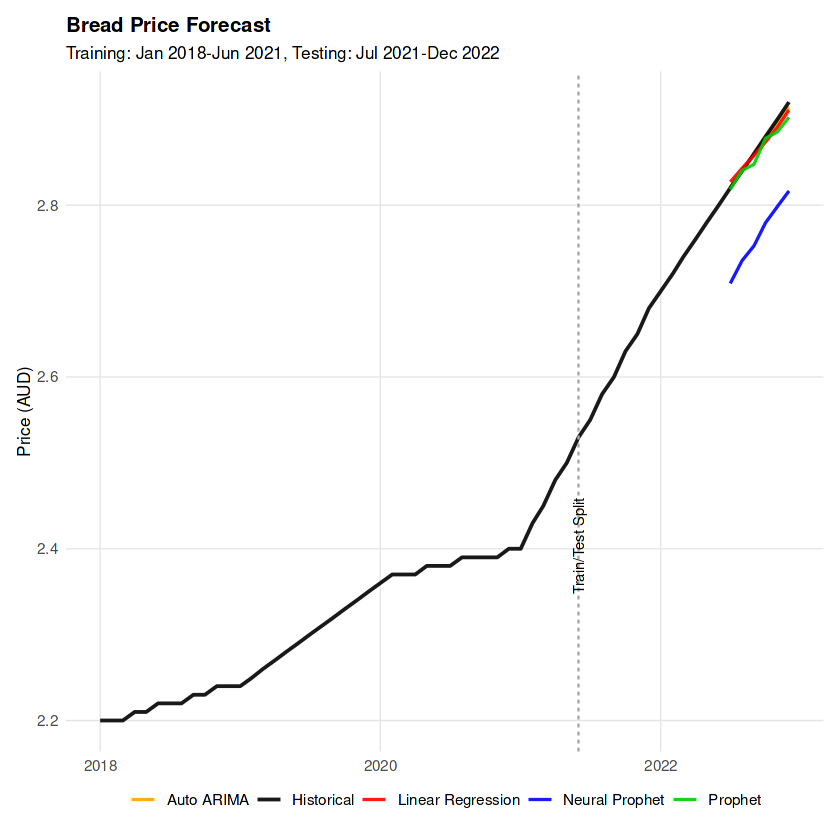


ANALYZING: Eggs 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 5.547 6.251 
Historical range: 3.41 5.46 
Prophet forecasting failed: Seasonality must be added prior to model fitting. 
Using simple trend forecast as fallback for Prophet
Running Neural Prophet...
Neural Prophet completed successfully


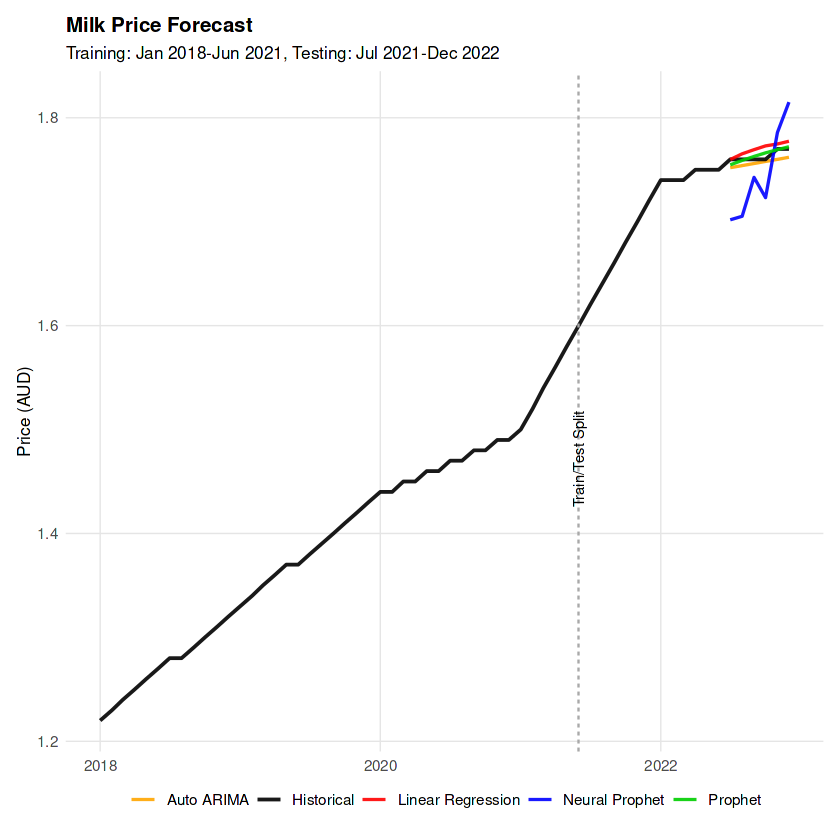


ANALYZING: Potatoes 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 3.853 3.943 
Historical range: 3.5 3.93 
Enhanced seasonal pattern for potatoes in southern hemisphere
Prophet forecasting failed: Seasonality must be added prior to model fitting. 
Using simple trend forecast as fallback for Prophet
Running Neural Prophet...
Neural Prophet completed successfully


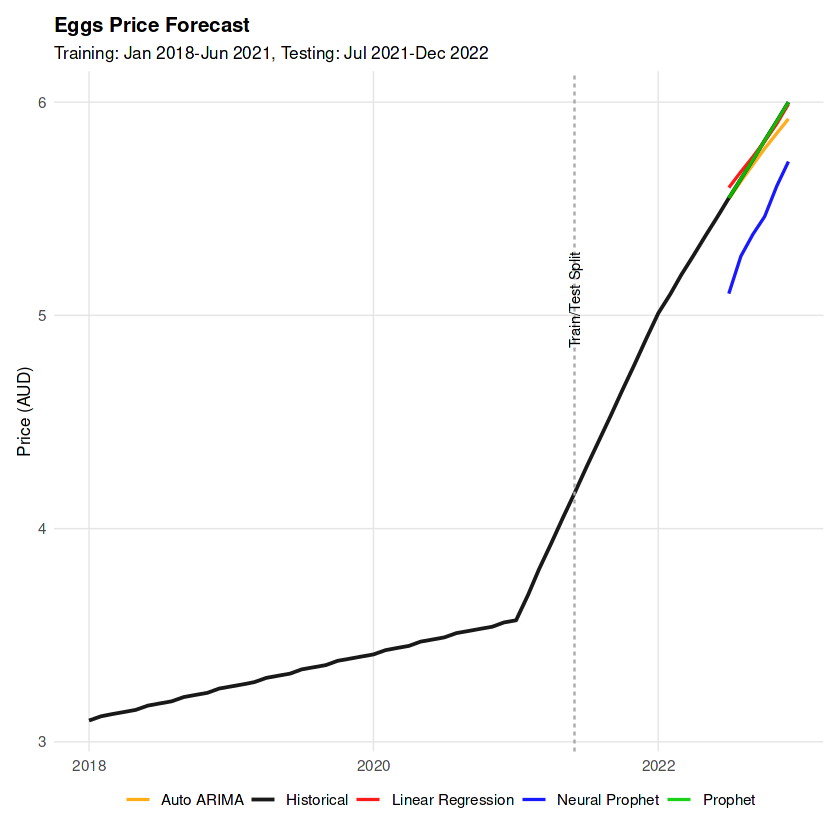


=== COMBINED VISUALIZATION OF ALL FOOD ITEMS ===


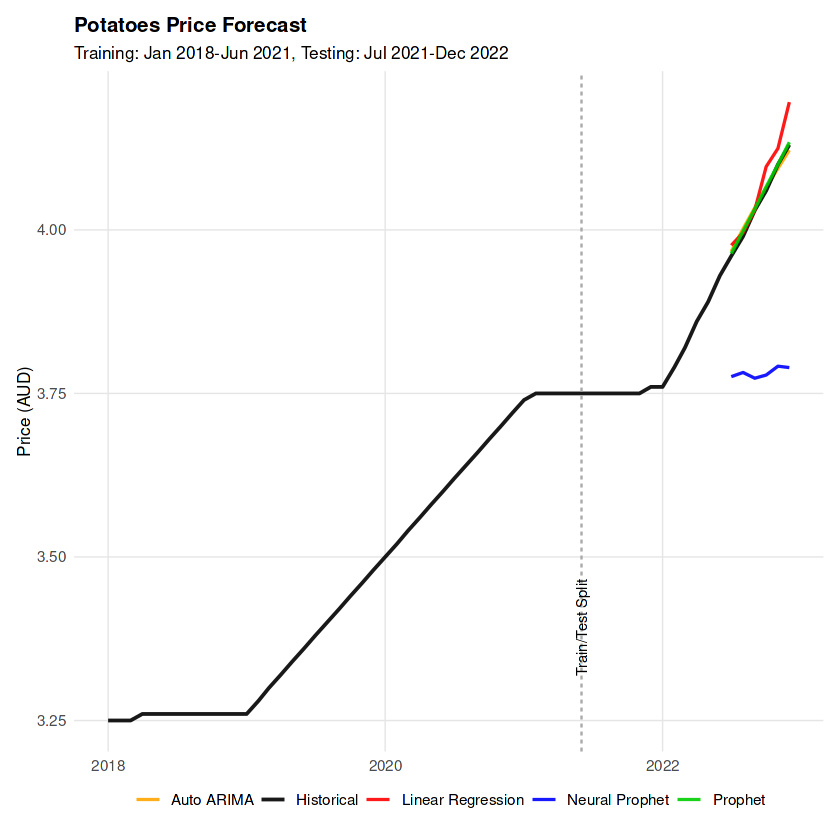

TableGrob (4 x 2) "arrange": 6 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (2-2,2-2) arrange      gtable[arrange]
3 3 (3-3,1-1) arrange      gtable[arrange]
4 4 (3-3,2-2) arrange      gtable[arrange]
5 5 (1-1,1-2) arrange text[GRID.text.9523]
6 6 (4-4,1-2) arrange    gtable[guide-box]


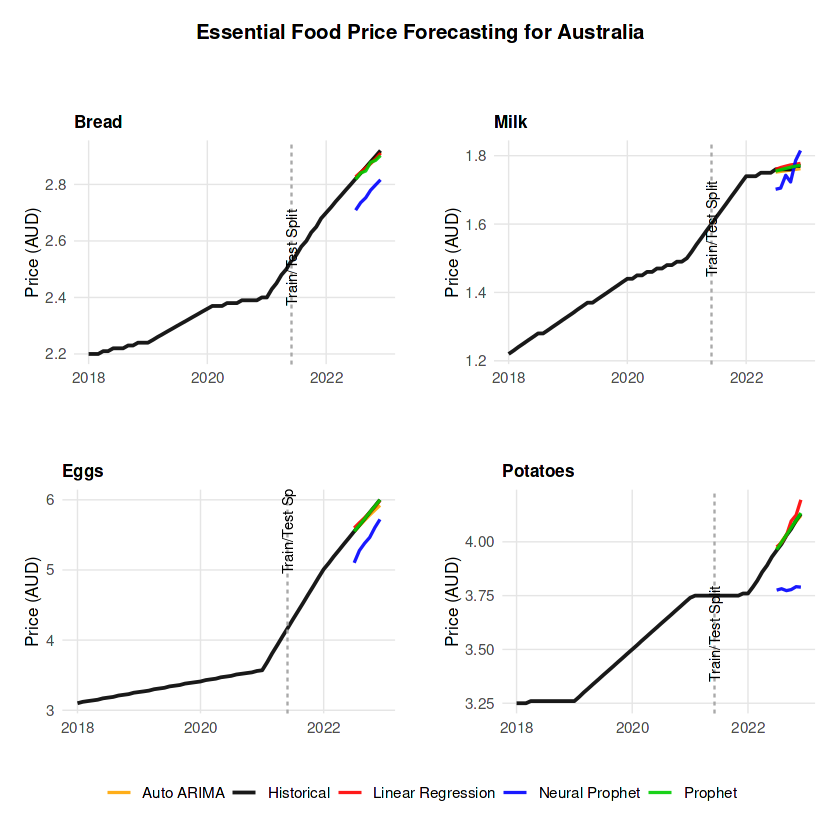

In [66]:
# --- 3. RUN COMPREHENSIVE ANALYSIS ---
cat("=== ESSENTIAL FOOD PRICE FORECASTING ANALYSIS ===\n")
cat("Training period: Jan 2018 - Jun 2021\n")
cat("Testing period: Jul 2021 - Dec 2022\n")

# Install required packages if not already installed
if (!require("knitr")) install.packages("knitr")

# Initialize results storage
all_results <- list()
all_metrics <- data.frame()

# Analyze each food item
for(item in names(food_items)) {
  # Add robust error handling
  tryCatch({
    result <- comprehensive_forecast_analysis(food_items[[item]], item)
    all_results[[item]] <- result
    
    # Add item name to metrics
    result$metrics$Item <- item
    all_metrics <- rbind(all_metrics, result$metrics)
  }, error = function(e) {
    cat("Error analyzing", item, ":", e$message, "\n")
    
    # ADDED: Create simpler fallback analysis
    # --- IMPROVED FALLBACK ANALYSIS SECTION ---
    cat("Attempting simpler analysis for", item, "...\n")
    tryCatch({
      # Get data splits
      train_data <- food_items[[item]] %>% 
        filter(date >= as.Date('2018-01-01') & date <= as.Date('2021-06-01'))
      test_data <- food_items[[item]] %>% 
        filter(date >= as.Date('2021-07-01') & date <= as.Date('2022-12-01'))
      
      # Ensure test data exists
      if(nrow(test_data) == 0) {
        cat("No test data available for", item, "\n")
        return(NULL)
      }
      
      test_actuals <- test_data$Average.Price
      
      # Safer linear model for fallback
      time_idx <- 1:nrow(train_data)
      lm_simple <- lm(Average.Price ~ time_idx, data = train_data)
      
      # Create prediction dataframe with matching columns
      pred_df <- data.frame(time_idx = nrow(train_data) + 1:nrow(test_data))
      lm_preds <- predict(lm_simple, newdata = pred_df)
      
      # Simple ARIMA with error handling
      ts_train <- ts(train_data$Average.Price, frequency = 12)
      arima_model <- forecast::auto.arima(ts_train, seasonal = TRUE, stepwise = TRUE)
      arima_preds <- as.numeric(forecast(arima_model, h = length(test_actuals))$mean)
      
      # Create fallback metrics safely
      fallback_metrics <- data.frame(
        Model = c("Linear Regression", "Auto ARIMA"),
        MAE = c(mean(abs(lm_preds - test_actuals)), mean(abs(arima_preds - test_actuals))),
        RMSE = c(sqrt(mean((lm_preds - test_actuals)^2)), sqrt(mean((arima_preds - test_actuals)^2))),
        MAPE = c(mean(abs((test_actuals - lm_preds)/test_actuals) * 100), 
                mean(abs((test_actuals - arima_preds)/test_actuals) * 100)),
        R2 = c(1 - sum((test_actuals - lm_preds)^2) / sum((test_actuals - mean(test_actuals))^2),
              1 - sum((test_actuals - arima_preds)^2) / sum((test_actuals - mean(test_actuals))^2)),
        Item = rep(item, 2)
      )
      
      all_metrics <- rbind(all_metrics, fallback_metrics)
      cat("Added fallback metrics for", item, "\n")
    }, error = function(e2) {
      cat("Fallback analysis also failed for", item, ":", e2$message, "\n")
    })
  })
}

# --- SHOW COMBINED VISUALIZATION FIRST ---
# Move this section before metrics tables
if(length(all_results) == 4 && all(sapply(all_results, function(x) !is.null(x$plot)))) {
  cat("\n=== COMBINED VISUALIZATION OF ALL FOOD ITEMS ===\n")
  
  # Add more spacing and reduce text size to avoid overlapping
  # Extract individual plots but remove their legends and simplify titles
  bread_plot <- all_results$Bread$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Bread", subtitle = NULL)
  
  milk_plot <- all_results$Milk$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Milk", subtitle = NULL)
  
  eggs_plot <- all_results$Eggs$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Eggs", subtitle = NULL)
  
  potatoes_plot <- all_results$Potatoes$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Potatoes", subtitle = NULL)
  
  # Create a simplified legend
  legend <- get_legend(
    all_results$Bread$plot + 
      guides(color = guide_legend(nrow = 1)) +
      theme(legend.position = "bottom")
  )
  
  # Use layout_matrix to add more space between plots
  combined_plot <- grid.arrange(
    arrangeGrob(bread_plot, top = textGrob("")),
    arrangeGrob(milk_plot, top = textGrob("")),
    arrangeGrob(eggs_plot, top = textGrob("")),
    arrangeGrob(potatoes_plot, top = textGrob("")),
    ncol = 2,
    nrow = 2,
    bottom = legend,
    top = textGrob("Essential Food Price Forecasting for Australia",
                  gp = gpar(fontsize = 12, fontface = "bold")),
    padding = unit(2, "line")  # Add padding between plots
  )
  
  print(combined_plot)
}


In [67]:

# --- NOW SHOW METRICS TABLES AFTER VISUALIZATIONS ---
# Ensure create_simple_metrics_table can handle empty data
if(nrow(all_metrics) == 0) {
  cat("No analyses succeeded. Cannot create metric tables.\n")
} else {
  cat("\n=== MODEL PERFORMANCE METRICS ===\n")
  # Create simple metrics tables
  metrics_tables <- create_simple_metrics_table(all_metrics)
  
  # Display individual metric comparisons
  cat("\n=== METRIC COMPARISON ACROSS MODELS ===\n")
  
  # MAE comparison
  cat("\nMean Absolute Error (MAE) by Model and Food Item:\n")
  mae_comparison <- all_metrics %>%
    select(Model, Item, MAE) %>%
    pivot_wider(names_from = Item, values_from = MAE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(mae_comparison)
  
  # RMSE comparison
  cat("\nRoot Mean Square Error (RMSE) by Model and Food Item:\n")
  rmse_comparison <- all_metrics %>%
    select(Model, Item, RMSE) %>%
    pivot_wider(names_from = Item, values_from = RMSE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(rmse_comparison)
  
  # MAPE comparison
  cat("\nMean Absolute Percentage Error (MAPE) by Model and Food Item:\n")
  mape_comparison <- all_metrics %>%
    select(Model, Item, MAPE) %>%
    pivot_wider(names_from = Item, values_from = MAPE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(mape_comparison)
  
  # R2 comparison
  cat("\nR-squared (R2) by Model and Food Item:\n")
  r2_comparison <- all_metrics %>%
    select(Model, Item, R2) %>%
    pivot_wider(names_from = Item, values_from = R2) %>%
    mutate(across(-Model, ~round(., 4)))
  print(r2_comparison)
  
  # Innovation R2 comparison
  cat("\nInnovation R-squared (Innovation_R2) by Model and Food Item:\n")
  innr2_comparison <- all_metrics %>%
    select(Model, Item, Innovation_R2) %>%
    pivot_wider(names_from = Item, values_from = Innovation_R2) %>%
    mutate(across(-Model, ~round(., 4)))
  print(innr2_comparison)
}


=== MODEL PERFORMANCE METRICS ===

Model Performance Metrics for Bread 
              Model    MAE   RMSE   MAPE      R2 Innovation_R2
1 Linear Regression 0.0062 0.0068 0.2141  0.9608        0.8882
2        Auto ARIMA 0.0021 0.0029 0.0731  0.9927        0.9748
3           Prophet 0.0081 0.0107 0.2808  0.9022        0.6590
4    Neural Prophet 0.1047 0.1047 3.6492 -8.4044      -25.7414

Model Performance Metrics for Milk 
              Model    MAE   RMSE   MAPE       R2 Innovation_R2
1 Linear Regression 0.0067 0.0078 0.3776  -1.7066       -2.6086
2        Auto ARIMA 0.0063 0.0069 0.3589  -1.1300       -1.2000
3           Prophet 0.0030 0.0037 0.1716   0.3941        0.4703
4    Neural Prophet 0.0380 0.0415 2.1569 -76.4578      -68.4348

Model Performance Metrics for Eggs 
              Model    MAE   RMSE   MAPE      R2 Innovation_R2
1 Linear Regression 0.0200 0.0256 0.3532  0.9722        0.9619
2        Auto ARIMA 0.0352 0.0437 0.5990  0.9191        0.7172
3           Prophet 0.0000 0.


=== CROSS-COUNTRY FORECAST TREND COMPARISON ===
Comparing food price forecast trends between countries

Comparing Bread price forecast trends between Australia and Canada

Generating forecasts for Australia and Canada ...

ANALYZING: Bread 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 2.818 2.902 
Historical range: 2.36 2.8 
Running Neural Prophet...
Neural Prophet completed successfully

ANALYZING: Bread 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Error in ARIMA selection: invalid 'type' (list) of argument 
Using default auto.arima
Running Enhanced Prophet (robust)...
Prophet forecast range: 3.21 3.257 
Historical range: 3.03 3.2 
Runnin

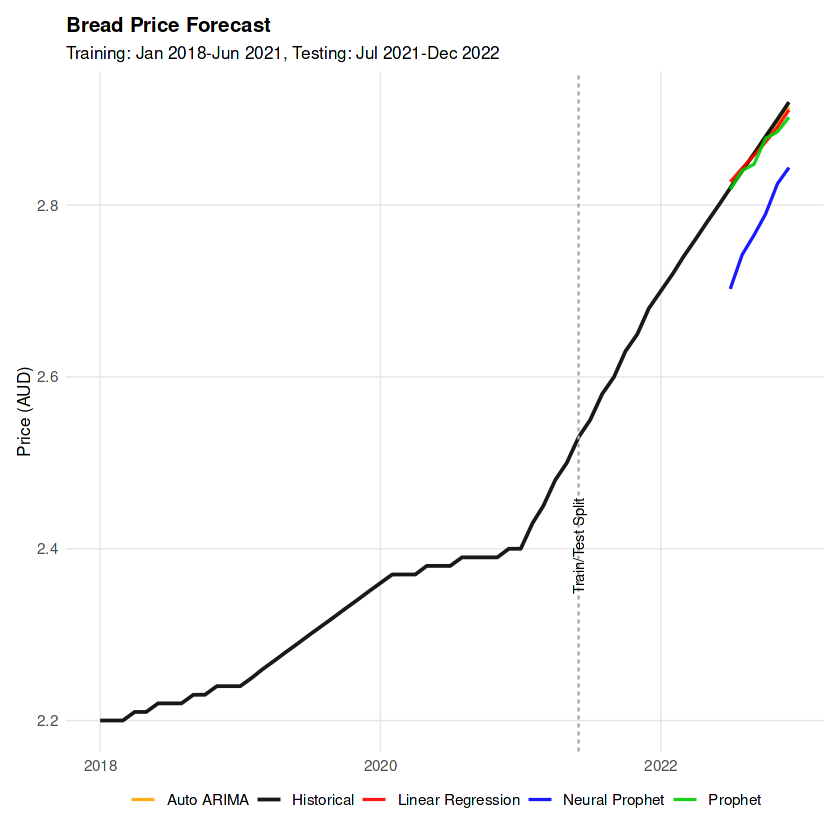


===== FORECAST TREND COMPARISON BETWEEN Australia AND Canada =====
Item: Bread 


--- Comparing ARIMA forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9997902
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9997902

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9999226
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation 0.986235274
2 Mean Growth Rate Difference 0.004428502

Shape (DTW) metrics:
                   Metric      Value
1            DTW Distance 0.17158152
2 Normalized DTW Distance 0.02859692

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3    Turning Point Density Ratio     1
4 Turning Point Count Difference     0

Overall similarity index: 0.9939 


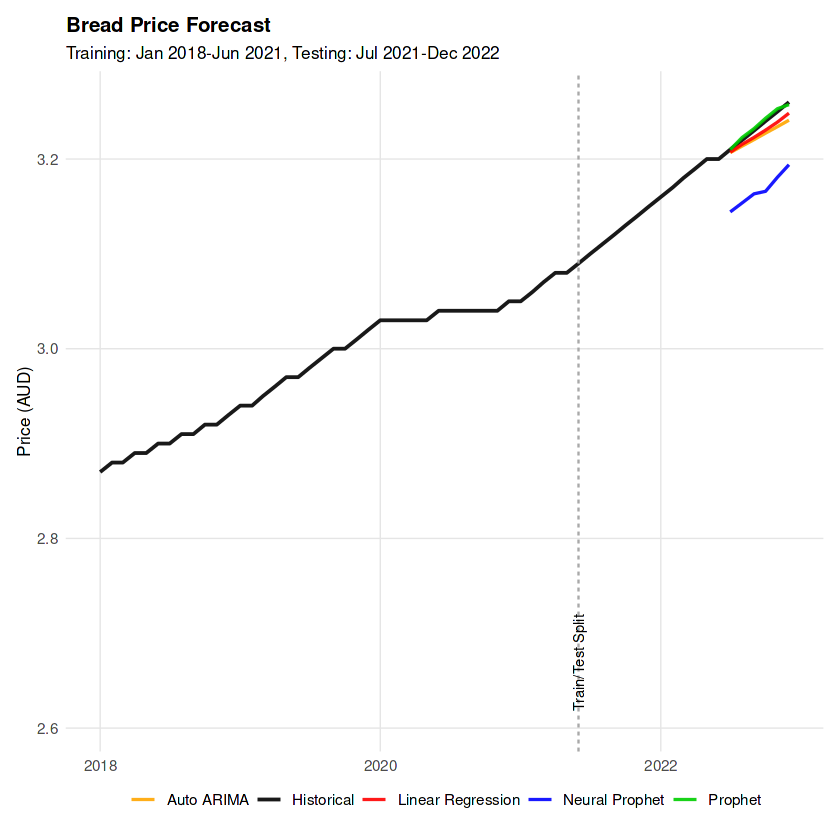


INTERPRETATION FOR ARIMA FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends are very similar 
The overall trends move strongly in the same direction 
The growth patterns are very similar 
The shapes of the forecasts are very similar 

--- Comparing Prophet forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9877714
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9877714

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9978204
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation 0.262500701
2 Mean Growth Rate Difference 0.003295139

Shape (DTW) metrics:
                   Metric     Value
1            DTW Distance 1.5122111
2 Normalized DTW Distance 0.2520352

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3    Turning Point Dens

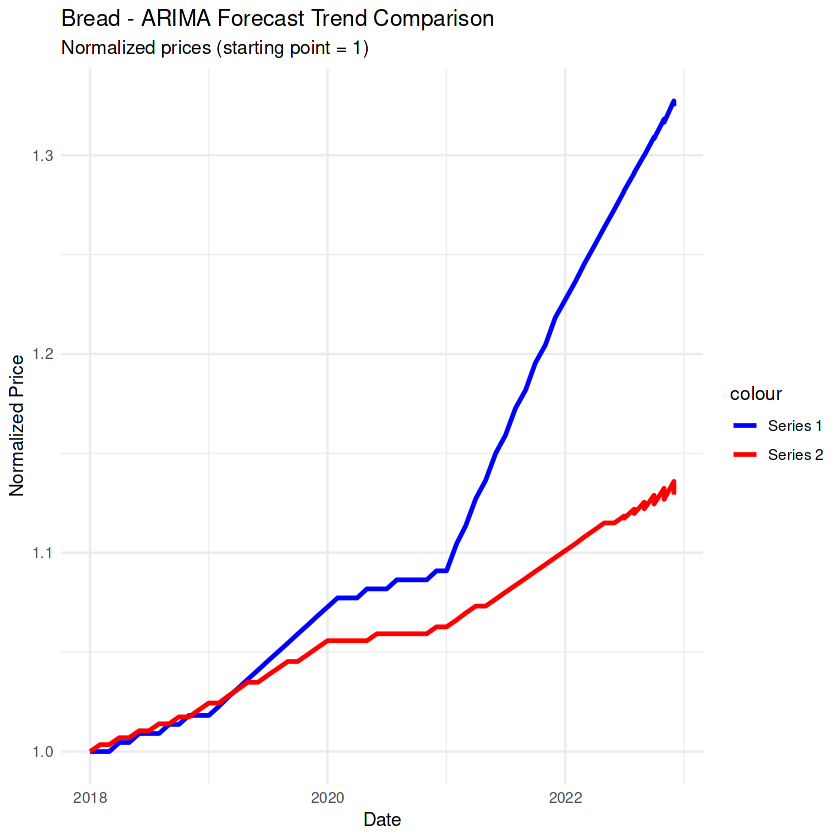


INTERPRETATION FOR Prophet FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends are very similar 
The overall trends move strongly in the same direction 
The growth patterns show weak similarity 
The shapes of the forecasts are very similar 

--- Comparing Linear Regression forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9998705
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9998705

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9999635
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation 0.942635663
2 Mean Growth Rate Difference 0.003295181

Shape (DTW) metrics:
                   Metric      Value
1            DTW Distance 0.14057976
2 Normalized DTW Distance 0.02342996

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3   

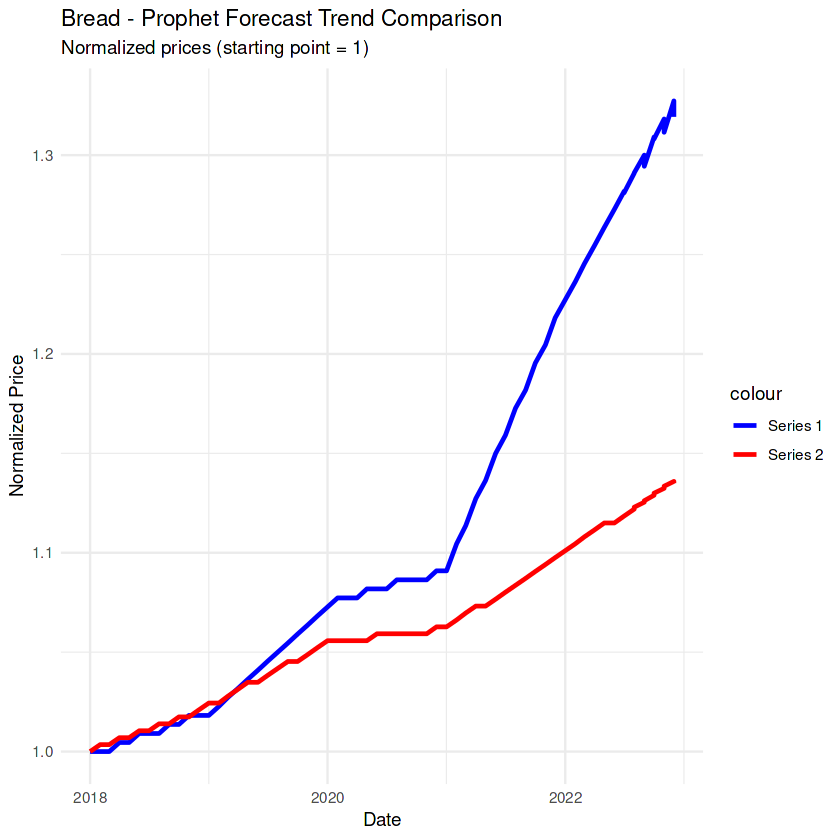


INTERPRETATION FOR Linear Regression FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends are very similar 
The overall trends move strongly in the same direction 
The growth patterns are very similar 
The shapes of the forecasts are very similar 

--- Comparing Neural Prophet forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9809924
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9809924

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9951184
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation 0.151155483
2 Mean Growth Rate Difference 0.007102387

Shape (DTW) metrics:
                   Metric     Value
1            DTW Distance 1.5779363
2 Normalized DTW Distance 0.2629894

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3   

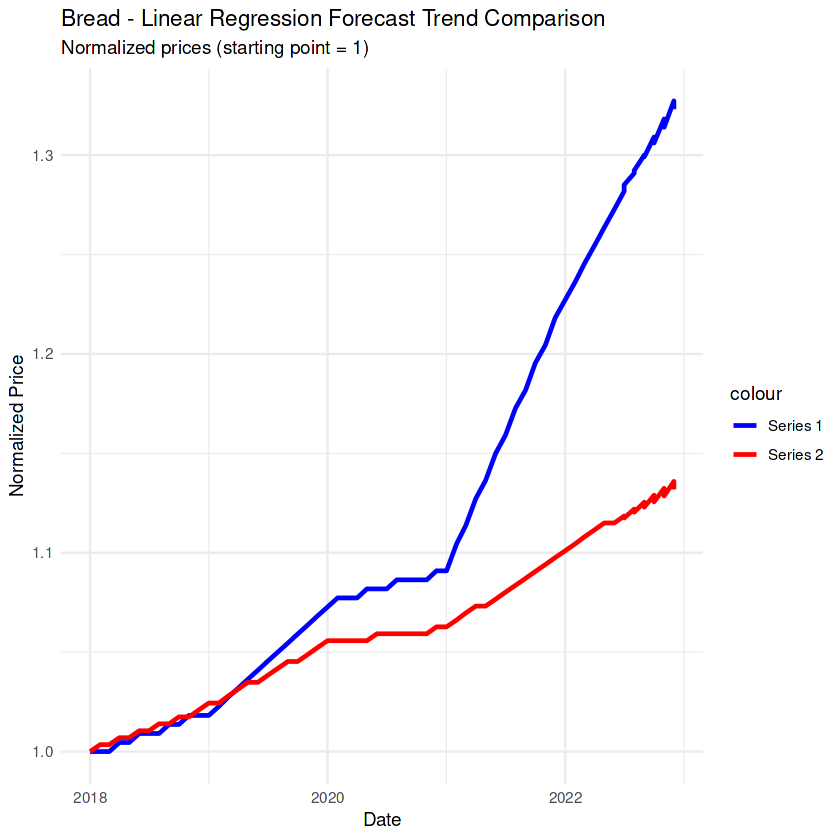


INTERPRETATION FOR Neural Prophet FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends show moderate similarity 
The overall trends move strongly in the same direction 
The growth patterns differ substantially 
The shapes of the forecasts are very similar 

--- SUMMARY OF FORECAST SIMILARITY ---
              Model Similarity_Index Pearson_Correlation Trend_Correlation
1             ARIMA        0.9938584           0.9997902         0.9999226
2 Linear Regression        0.9858048           0.9998705         0.9999635
3           Prophet        0.8226446           0.9877714         0.9978204
4    Neural Prophet        0.7960552           0.9809924         0.9951184
  Growth_Correlation DTW_Distance
1          0.9862353   0.02859692
2          0.9426357   0.02342996
3          0.2625007   0.25203518
4          0.1511555   0.26298939

Comparing Milk price forecast trends between Australia and Sweden

Generating forecasts for Australia and Sweden ...

ANALYZING: Milk 
Performing Feat

Warning message in predict.lm(lm_model, newdata = test_features):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Running Enhanced Auto ARIMA...
Error in ARIMA selection: system is computationally singular: reciprocal condition number = 8.53174e-17 
Using default auto.arima
Running Enhanced Prophet (robust)...
Prophet forecast range: 1.754 1.858 
Historical range: 1.44 1.75 
Detected price plateau pattern in milk - applying plateau adjustment
Running Neural Prophet...
Neural Prophet completed successfully

ANALYZING: Milk 
Performing Feature Engineering...
Break point detection failed: cannot coerce type 'closure' to vector of type 'double' 
Running Enhanced Linear Regression...


Warning message in predict.lm(lm_model, newdata = test_features):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


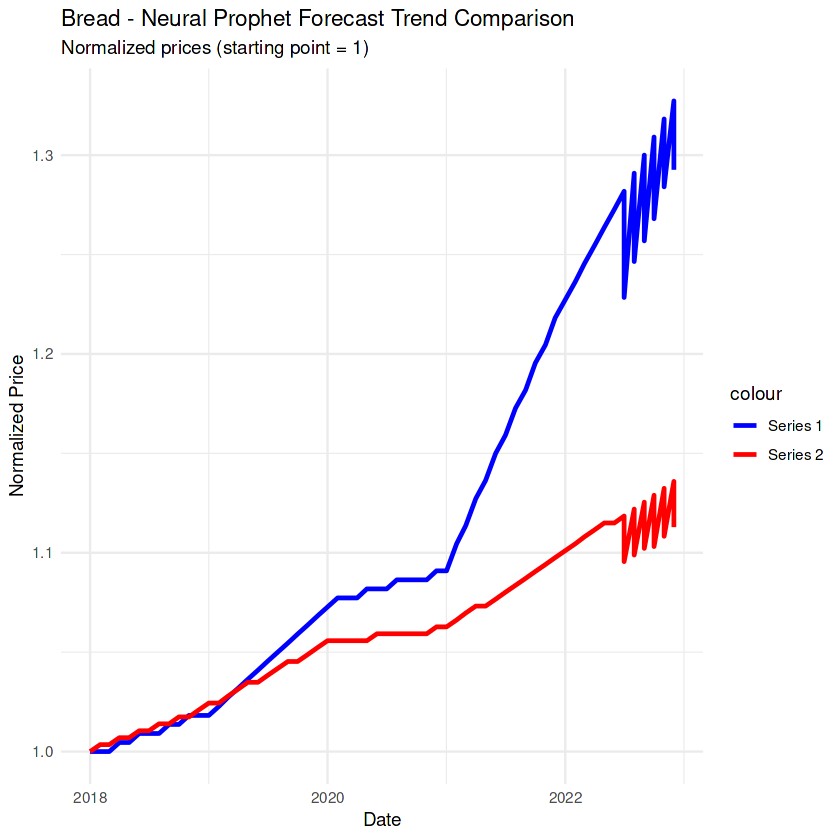

Running Enhanced Auto ARIMA...
Error in ARIMA selection: system is computationally singular: reciprocal condition number = 2.57083e-21 
Using default auto.arima
Running Enhanced Prophet (robust)...
Prophet forecast range: 13.622 14.105 
Historical range: 11.74 13.54 
Detected price plateau pattern in milk - applying plateau adjustment
Running Neural Prophet...
Neural Prophet completed successfully


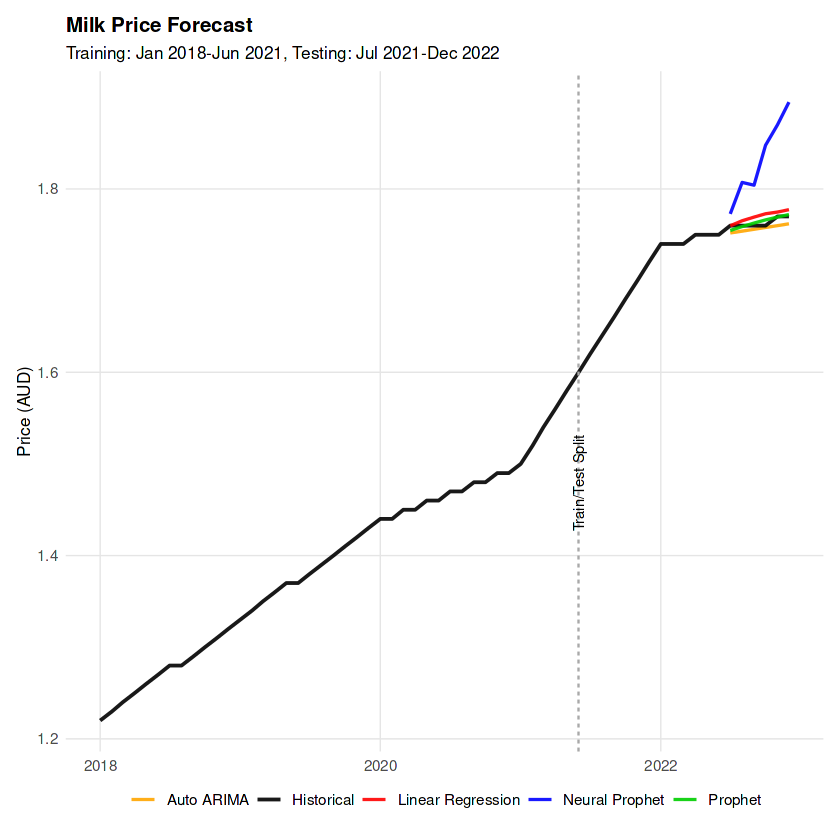


===== FORECAST TREND COMPARISON BETWEEN Australia AND Sweden =====
Item: Milk 


--- Comparing ARIMA forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9998175
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9998175

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9999465
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation 0.597438544
2 Mean Growth Rate Difference 0.005572755

Shape (DTW) metrics:
                   Metric      Value
1            DTW Distance 0.18983923
2 Normalized DTW Distance 0.03163987

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3    Turning Point Density Ratio     1
4 Turning Point Count Difference     0

Overall similarity index: 0.9157 


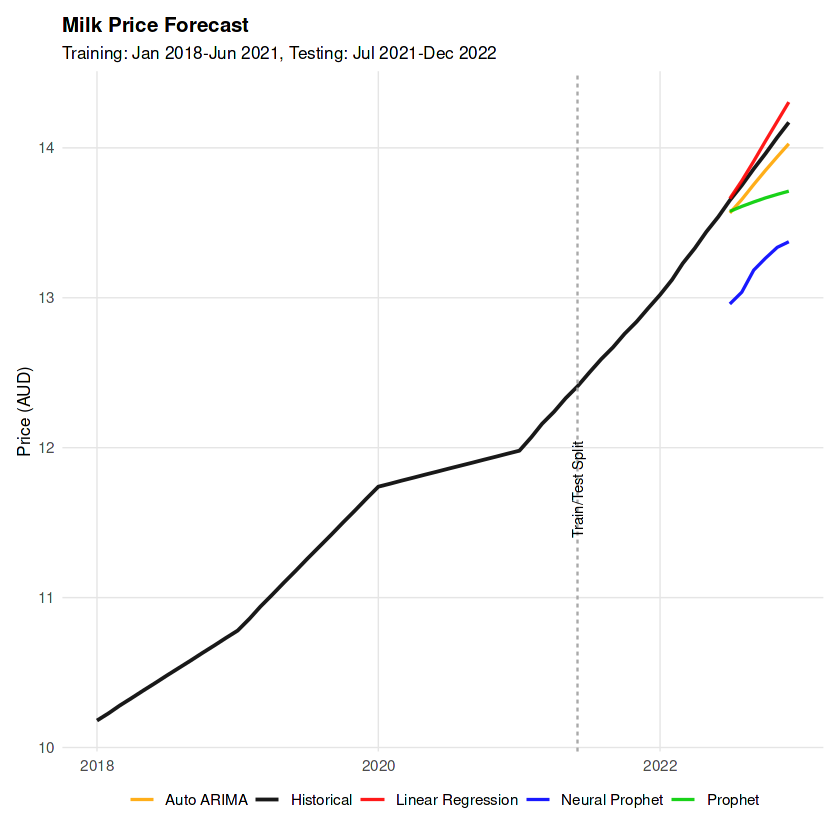


INTERPRETATION FOR ARIMA FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends are very similar 
The overall trends move strongly in the same direction 
The growth patterns show moderate similarity 
The shapes of the forecasts are very similar 

--- Comparing Prophet forecasts ---
Correlation metrics:
                 Metric Value
1   Pearson Correlation     1
2  Spearman Correlation     1
3 Max Cross-Correlation     1

Trend metrics:
                 Metric Value
1  MA Trend Correlation     1
2 Direction Consistency     1

Growth pattern metrics:
                       Metric        Value
1     Growth Rate Correlation 1.000000e+00
2 Mean Growth Rate Difference 1.241195e-16

Shape (DTW) metrics:
                   Metric        Value
1            DTW Distance 1.957878e-13
2 Normalized DTW Distance 3.263131e-14

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3    Turning Point Density Rati

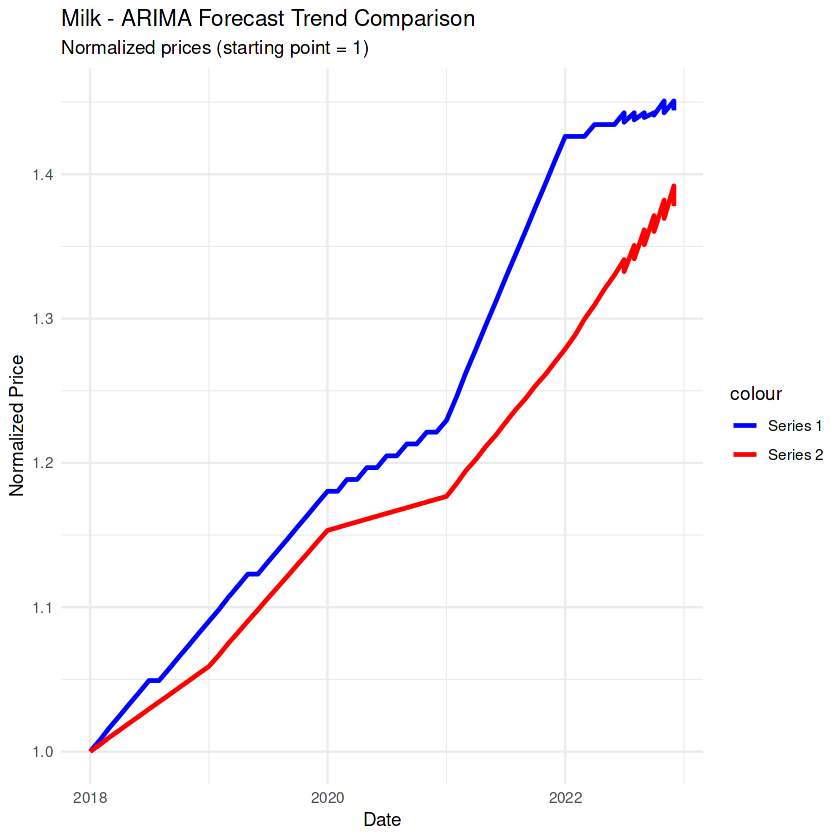


INTERPRETATION FOR Prophet FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends are very similar 
The overall trends move strongly in the same direction 
The growth patterns are very similar 
The shapes of the forecasts are very similar 

--- Comparing Linear Regression forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9815418
2  Spearman Correlation 1.0000000
3 Max Cross-Correlation 0.9815418

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9929135
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric        Value
1     Growth Rate Correlation -0.601683310
2 Mean Growth Rate Difference  0.007254979

Shape (DTW) metrics:
                   Metric     Value
1            DTW Distance 1.7452784
2 Normalized DTW Distance 0.2908797

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     2
2   Turning Point Count Series 2     2
3    Tur

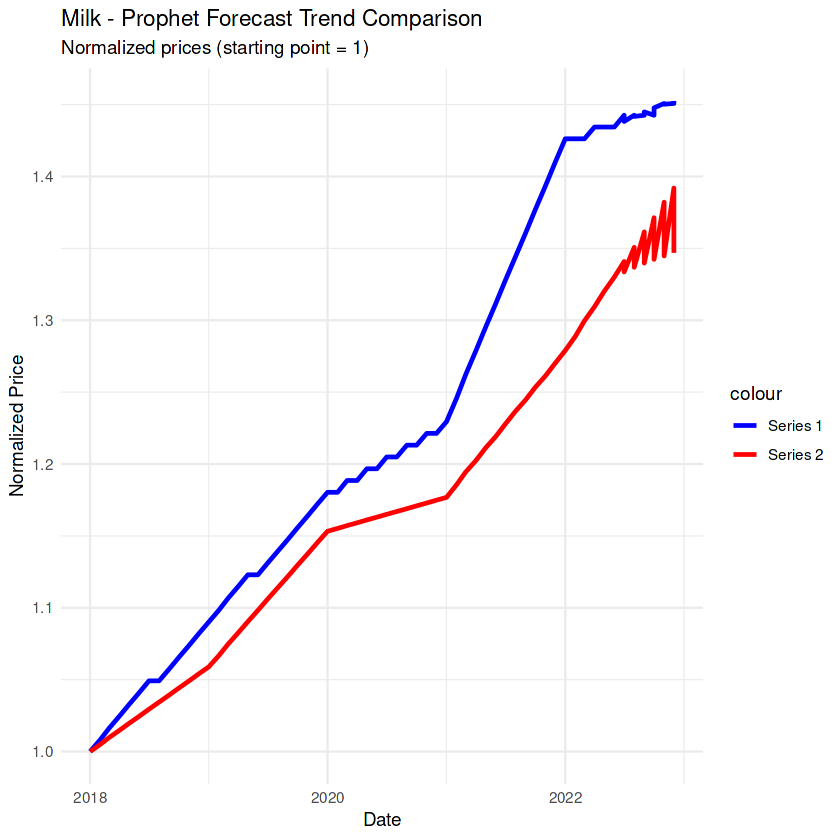


INTERPRETATION FOR Linear Regression FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends show moderate similarity 
The overall trends move strongly in the same direction 
The growth patterns differ substantially 
The shapes of the forecasts are very similar 

--- Comparing Neural Prophet forecasts ---
Correlation metrics:
                 Metric     Value
1   Pearson Correlation 0.9436101
2  Spearman Correlation 0.9428571
3 Max Cross-Correlation 0.9436101

Trend metrics:
                 Metric     Value
1  MA Trend Correlation 0.9856297
2 Direction Consistency 1.0000000

Growth pattern metrics:
                       Metric       Value
1     Growth Rate Correlation -0.65700718
2 Mean Growth Rate Difference  0.01228193

Shape (DTW) metrics:
                   Metric     Value
1            DTW Distance 2.5697472
2 Normalized DTW Distance 0.4282912

Turning point metrics:
                          Metric Value
1   Turning Point Count Series 1     4
2   Turning Point Count Series 

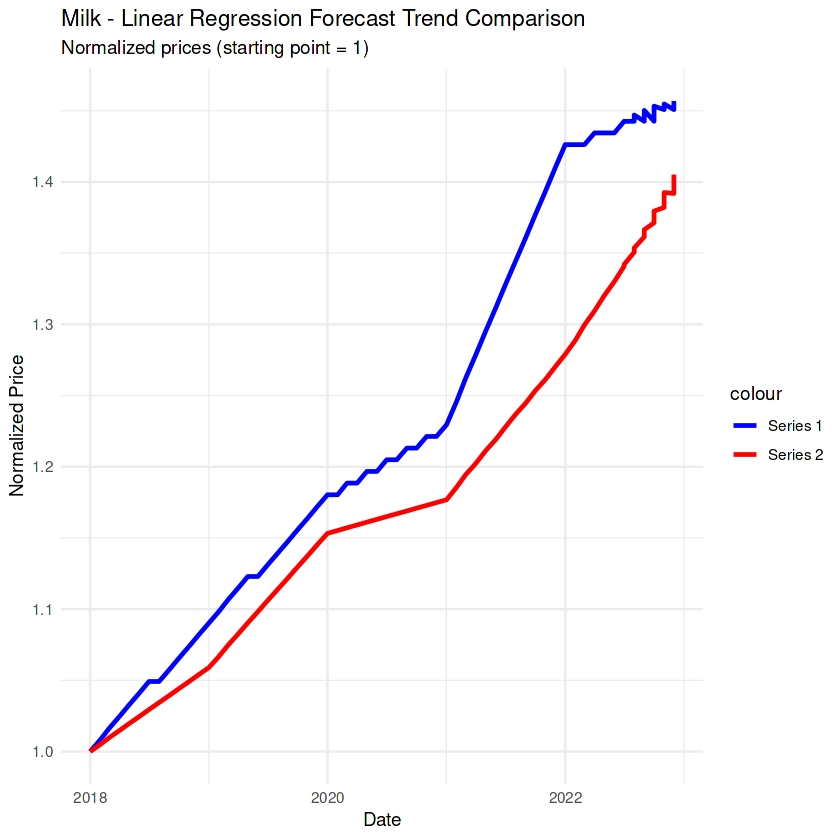


INTERPRETATION FOR Neural Prophet FORECASTS:
SIMILARITY INTERPRETATION:

The forecast trends show moderate similarity 
The overall trends move strongly in the same direction 
The growth patterns differ substantially 
The shapes of the forecasts are very similar 

--- SUMMARY OF FORECAST SIMILARITY ---
              Model Similarity_Index Pearson_Correlation Trend_Correlation
1           Prophet        1.0000000           1.0000000         1.0000000
2             ARIMA        0.9156957           0.9998175         0.9999465
3 Linear Regression        0.6421865           0.9815418         0.9929135
4    Neural Prophet        0.6033132           0.9436101         0.9856297
  Growth_Correlation DTW_Distance
1          1.0000000 3.263131e-14
2          0.5974385 3.163987e-02
3         -0.6016833 2.908797e-01
4         -0.6570072 4.282912e-01


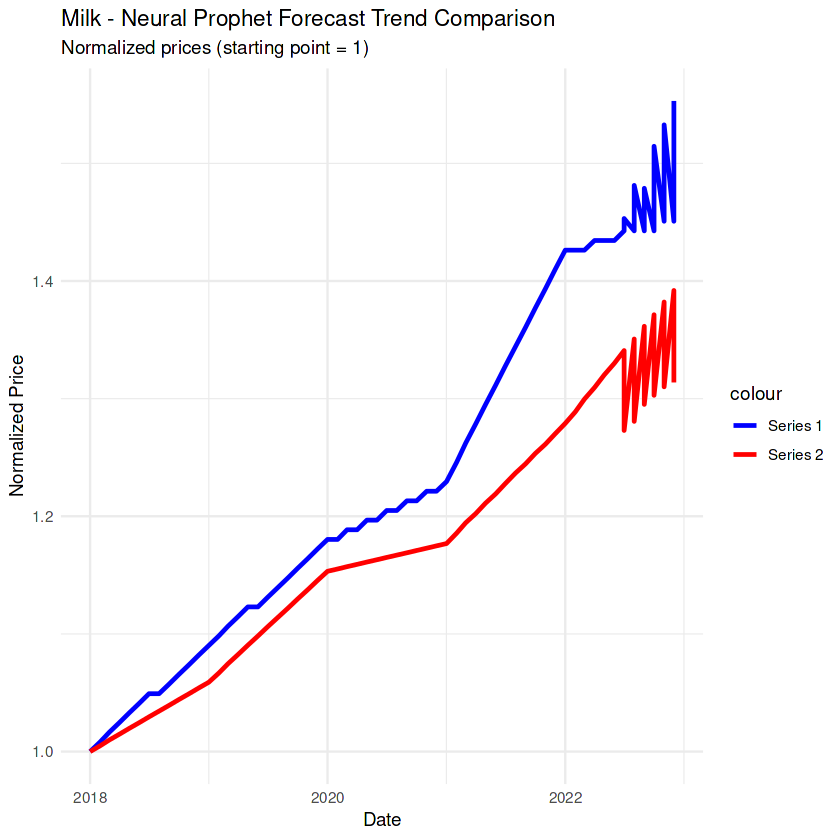

In [68]:
# --- 5. CROSS-COUNTRY FORECAST TREND COMPARISON ---
cat("\n=== CROSS-COUNTRY FORECAST TREND COMPARISON ===\n")
cat("Comparing food price forecast trends between countries\n")

# Install required packages
if (!require("dtw")) install.packages("dtw")

# Create a filter function to get data for a specific country and item
get_country_item_data <- function(df, country_name, item_name) {
  df %>% 
    filter(Country == country_name, Food.Item == item_name) %>%
    arrange(date)
}

# Example: Compare bread price forecasts between Australia and Canada
cat("\nComparing Bread price forecast trends between Australia and Canada\n")

# Get data for both countries
australia_bread <- get_country_item_data(df, "Australia", "Bread")
canada_bread <- get_country_item_data(df, "Canada", "Bread")

# Run the comparison function
bread_comparison <- compare_country_forecasts(
  australia_bread, 
  canada_bread, 
  "Australia", 
  "Canada", 
  "Bread"
)

# Example: Compare milk price forecasts between Australia and Sweden
cat("\nComparing Milk price forecast trends between Australia and Sweden\n")

# Get data for both countries
australia_milk <- get_country_item_data(df, "Australia", "Milk")
sweden_milk <- get_country_item_data(df, "Sweden", "Milk")

# Run the comparison function
milk_comparison <- compare_country_forecasts(
  australia_milk, 
  sweden_milk, 
  "Australia", 
  "Sweden", 
  "Milk"
)

# Create a heatmap of similarities across countries and items
# This would require additional comparisons across more countries

In [69]:
# --- 6. PROPHET CROSS-VALIDATION AND HYPERPARAMETER TUNING ---
tune_prophet_model <- function(data, item_name, country_name) {
  cat("\nTuning Prophet model for", item_name, "in", country_name, "\n")
  
  # Define parameter grid to search
  param_grid <- expand.grid(
    changepoint_prior_scale = c(0.005, 0.01, 0.05),
    seasonality_prior_scale = c(1, 5, 10),
    seasonality_mode = c("additive", "multiplicative"),
    n_changepoints = c(10, 20)
  )
  
  # Create training and validation sets
  train_data <- data %>% filter(date <= as.Date('2021-01-01'))
  valid_data <- data %>% filter(date > as.Date('2021-01-01') & date <= as.Date('2021-12-01'))
  
  # Storage for results
  results <- data.frame(
    row = 1:nrow(param_grid),
    changepoint_prior_scale = param_grid$changepoint_prior_scale,
    seasonality_prior_scale = param_grid$seasonality_prior_scale,
    seasonality_mode = param_grid$seasonality_mode,
    n_changepoints = param_grid$n_changepoints,
    mae = NA,
    rmse = NA
  )
  
  # Run cross-validation
  for(i in 1:nrow(param_grid)) {
    tryCatch({
      # Create prophet model with these parameters
      model <- prophet(
        changepoint.prior.scale = param_grid$changepoint_prior_scale[i],
        seasonality.prior.scale = param_grid$seasonality_prior_scale[i],
        seasonality.mode = param_grid$seasonality_mode[i],
        n.changepoints = param_grid$n_changepoints[i],
        weekly.seasonality = FALSE,
        daily.seasonality = FALSE
      )
      
      # Add additional seasonality based on country
      if(country_name %in% c("Australia", "South Africa")) {
        model <- add_seasonality(model, name = 'quarterly', period = 91.25, fourier.order = 5)
      }
      
      # Fit model
      df <- train_data %>% select(date, Average.Price) %>% rename(ds = date, y = Average.Price)
      model <- fit.prophet(model, df)
      
      # Generate predictions
      future <- make_future_dataframe(model, periods = nrow(valid_data), freq = "month")
      forecast <- predict(model, future)
      
      # Extract validation predictions
      valid_preds <- tail(forecast$yhat, nrow(valid_data))
      
      # Calculate metrics
      results$mae[i] <- mean(abs(valid_preds - valid_data$Average.Price))
      results$rmse[i] <- sqrt(mean((valid_preds - valid_data$Average.Price)^2))
      
      cat("Completed parameter set", i, "of", nrow(param_grid), "\n")
    }, error = function(e) {
      cat("Error with parameter set", i, ":", e$message, "\n")
    })
  }
  
  # Find best configuration
  best_idx <- which.min(results$mae)
  cat("\nBest parameters based on MAE:\n")
  print(results[best_idx, ])
  
  return(results)
}

# Example usage:
# Run only if you want to find optimal parameters for a specific country/item combination
if(FALSE) {
  australia_bread <- df %>% 
    filter(Country == "Australia", Food.Item == "Bread") %>%
    arrange(date)
  
  bread_params <- tune_prophet_model(australia_bread, "Bread", "Australia")
}

In [70]:
# --- 7. COMPARE PROPHET CONFIGURATIONS ACROSS COUNTRIES ---
compare_prophet_configs <- function(data, item_name) {
  # Get unique countries
  countries <- unique(data$Country)
  
  # Store results
  all_forecasts <- list()
  metrics <- data.frame()
  
  # Run forecast for each country
  for(country in countries) {
    cat("\nRunning Prophet forecast for", item_name, "in", country, "\n")
    
    # Filter data for this country
    country_data <- data %>% 
      filter(Country == country, Food.Item == item_name) %>%
      arrange(date)
    
    # Skip if insufficient data
    if(nrow(country_data) < 24) {
      cat("Insufficient data for", country, "- skipping\n")
      next
    }
    
    # Split data
    train_data <- country_data %>% filter(date <= as.Date('2021-06-01'))
    test_data <- country_data %>% filter(date > as.Date('2021-06-01'))
    test_dates <- test_data$date
    test_actuals <- test_data$Average.Price
    
    # Get optimized configuration
    prophet_config <- optimize_prophet_for_country(item_name, country)
    
    # Prepare Prophet data
    prophet_df <- train_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    
    # Create and fit model
    prophet_model <- prophet(
      changepoint.prior.scale = prophet_config$changepoint_prior_scale,
      changepoint.range = prophet_config$changepoint_range,
      n.changepoints = prophet_config$n_changepoints,
      yearly.seasonality = prophet_config$yearly_seasonality,
      weekly.seasonality = FALSE,
      daily.seasonality = FALSE,
      seasonality.mode = prophet_config$seasonality_mode,
      seasonality.prior.scale = prophet_config$seasonality_prior_scale,
      growth = prophet_config$growth,
      interval.width = 0.8
    )
    
    # Add country-specific seasonality
    if(country %in% c("Australia", "South Africa")) {
      prophet_model <- add_seasonality(prophet_model, 
                                      name = 'quarterly', 
                                      period = 91.25, 
                                      fourier.order = 5)
    }
    
    # For regions with agricultural price controls
    if(country %in% c("Japan", "Canada", "Sweden") && item_name %in% c("Milk", "Bread")) {
      prophet_model <- add_seasonality(prophet_model, 
                                      name = 'biannual', 
                                      period = 182.5, 
                                      fourier.order = 3)
    }
    
    # Fit model and forecast
    prophet_model <- fit.prophet(prophet_model, prophet_df)
    future <- make_future_dataframe(prophet_model, periods = nrow(test_data), freq = "month")
    forecast <- predict(prophet_model, future)
    prophet_preds <- tail(forecast$yhat, nrow(test_data))
    
    # Calculate metrics
    mae <- mean(abs(prophet_preds - test_actuals))
    rmse <- sqrt(mean((prophet_preds - test_actuals)^2))
    mape <- mean(abs((test_actuals - prophet_preds)/test_actuals) * 100)
    
    # Store results
    all_forecasts[[country]] <- list(
      dates = test_dates,
      actuals = test_actuals,
      preds = prophet_preds,
      config = prophet_config
    )
    
    metrics <- rbind(metrics, data.frame(
      Country = country,
      MAE = mae,
      RMSE = rmse,
      MAPE = mape
    ))
  }
  
  # Create comparison plot
  if(length(all_forecasts) > 0) {
    plot_data <- data.frame()
    
    for(country in names(all_forecasts)) {
      country_results <- all_forecasts[[country]]
      plot_data <- rbind(plot_data, data.frame(
        Date = country_results$dates,
        Value = country_results$preds,
        Type = paste0(country, " (Forecast)"),
        Country = country
      ))
      
      plot_data <- rbind(plot_data, data.frame(
        Date = country_results$dates,
        Value = country_results$actuals,
        Type = paste0(country, " (Actual)"),
        Country = country
      ))
    }
    
    # Create comparison plot
    comparison_plot <- ggplot(plot_data, aes(x = Date, y = Value, color = Type, linetype = Type)) +
      geom_line(size = 1) +
      labs(title = paste("Prophet Forecast Comparison for", item_name),
           subtitle = "Comparing forecast quality across countries",
           x = "Date", y = "Price") +
      theme_minimal() +
      theme(legend.position = "bottom")
    
    print(comparison_plot)
    
    # Print metrics
    cat("\nForecast Metrics Comparison:\n")
    print(metrics)
    
    return(list(forecasts = all_forecasts, metrics = metrics, plot = comparison_plot))
  }
}

# Example usage:
# To compare Prophet forecasts for Bread across all countries:
# bread_comparison <- compare_prophet_configs(df, "Bread")